In [5]:
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib
import statsmodels
from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
import cycler
import warnings

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = \
    r'\usepackage{amssymb} \usepackage{amsmath} \usepackage{xcolor}' + \
    r'\renewcommand*\familydefault{\sfdefault}'
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
matplotlib.rcParams['pgf.preamble']  = \
    r'\usepackage[utf8x]{inputenc} \usepackage{amssymb}' + \
    r'\usepackage[T1]{fontenc} \usepackage{amsmath} \usepackage{sansmath}'

ax = np.newaxis
norm = np.linalg.norm
warnings.filterwarnings("ignore")
kernel_est = statsmodels.nonparametric.kde.KDEUnivariate

In [6]:
data = pd.read_csv('ps3_auction.csv')
data.head()

,Experiment,Period,Subject,Value,BidC3_o,Unnamed: 5,BidNC,Market,BidC3,BidC6,Ncont,Size6,Vh,BidC6.1
0,3,5,1,9.21,8.00,.,.,1,8.00,8.50,0,0,30,8.50
1,3,5,2,4.38,4.00,.,.,0,4.00,4.25,0,0,30,4.25
2,3,5,3,28.05,21.05,.,.,0,21.05,22.05,0,0,30,22.05
3,3,5,4,26.44,20.44,.,.,1,20.44,21.44,0,0,30,21.44
4,3,5,5,21.49,18.49,.,.,0,18.49,19.49,0,0,30,19.49


### Part 1 - Question 1

In [7]:
data['bid_RNBN3'] = data['Value'] * 2/3
data['bid_RNBN6'] = data['Value'] * 5/6

data['diff_BN3'] = data['BidC3'] - data['bid_RNBN3']
data['diff_BN6'] = data['BidC6'] - data['bid_RNBN6']

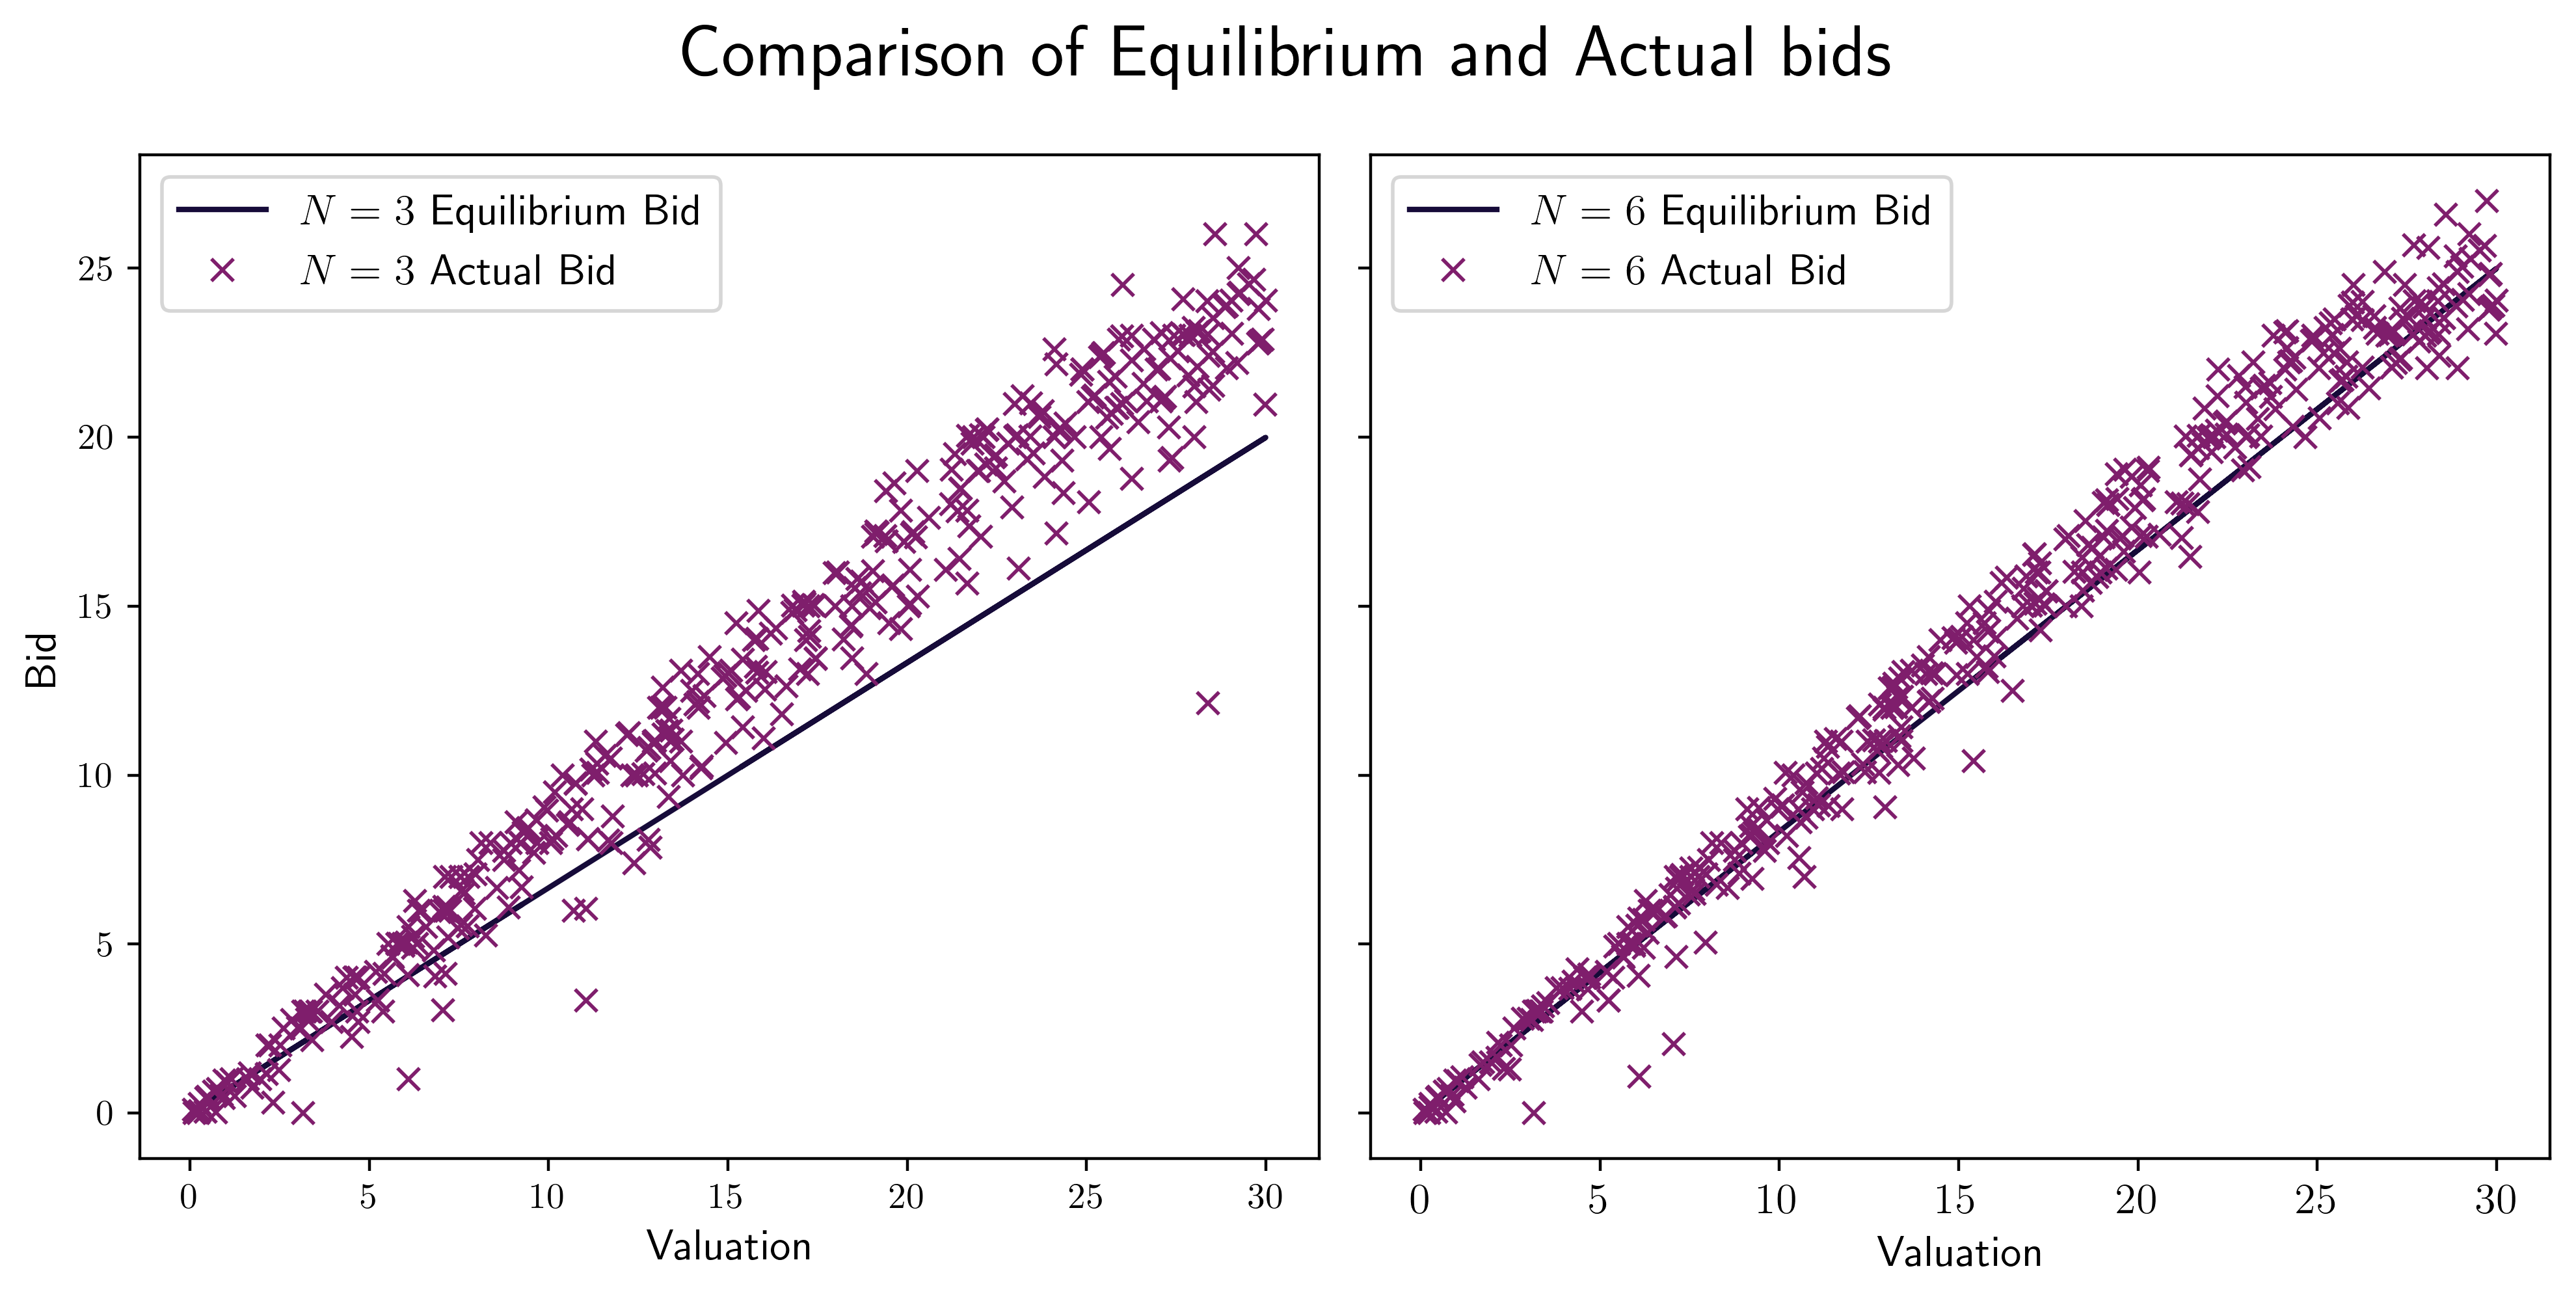

In [13]:
fig3, ax3 = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True, dpi=400, sharey='row')
color = plt.cm.inferno(np.linspace(0.1, 0.9, 3))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

ax3[0].plot(data['Value'], data['bid_RNBN3'], label= r'$N = 3$ Equilibrium Bid')
ax3[0].plot(data['Value'], data['BidC3'], label= r'$N = 3$ Actual Bid', marker='x', linestyle='')

ax3[1].plot(data['Value'], data['bid_RNBN6'], label= r'$N = 6$ Equilibrium Bid')
ax3[1].plot(data['Value'], data['BidC6'], label= r'$N = 6$ Actual Bid', marker='x', linestyle='')

ax3[0].legend(fontsize=12, ncol=1);
ax3[0].set_ylabel('Bid', fontsize=12);
ax3[0].set_xlabel('Valuation', fontsize=12);

ax3[1].legend(fontsize=12, ncol=1);
ax3[1].set_xlabel('Valuation', fontsize=12);

fig3.suptitle('Comparison of Equilibrium and Actual bids', fontsize=20, y=0.99);
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

In [14]:
def return_empirical_cdf(grid, exp, num_bid):

    """
    Computes the empirical CDF over a specified 1D grid for the bids within an experiment
        and given number of players.
    :param grid: Support of empirical CDF.
    :param exp: Experiment number.
    :param num_bid: Number of bidders.
    :return: CDF over the support.
    """

    if 3 <= exp <= 5:

        count_below = lambda x : data.query('Experiment == {} and BidC{} <= {}'.format(exp, num_bid, x)).Experiment.count()
        count_total = data.query('Experiment == {}'.format(exp)).Experiment.count()

    else:

        count_below = lambda x : data.query('BidC{} <= {}'.format(num_bid, x)).Experiment.count()
        count_total = data.Experiment.count()

    count_data = np.vectorize(count_below)(grid)


    return count_data/count_total

In [15]:
def compute_util_max_bid(grid, cdf, num_bid):

    v_grid = grid
    b_grid = grid
    util = (v_grid[:, ax] - b_grid[ax, :]) * (cdf[np.array(b_grid * 100, dtype=int)]) ** (num_bid - 1)

    b_max = util.max(axis=1)

    return b_max


Pretty sure that Equation 4 is wrong as printed. I match the optimization errors given in Table 1 when I use the following equation:

$$
    \omega(b, v ; N, e) \; = \; \left[ \max_{b^{\prime}}\left(v-b^{\prime}\right) \cdot \hat{Q}\left(b^{\prime} ; N, e\right)^{N-1}\right] - \hat{\pi}(b, v ; N, e)
$$

### Part 1 - Question 2 and 3

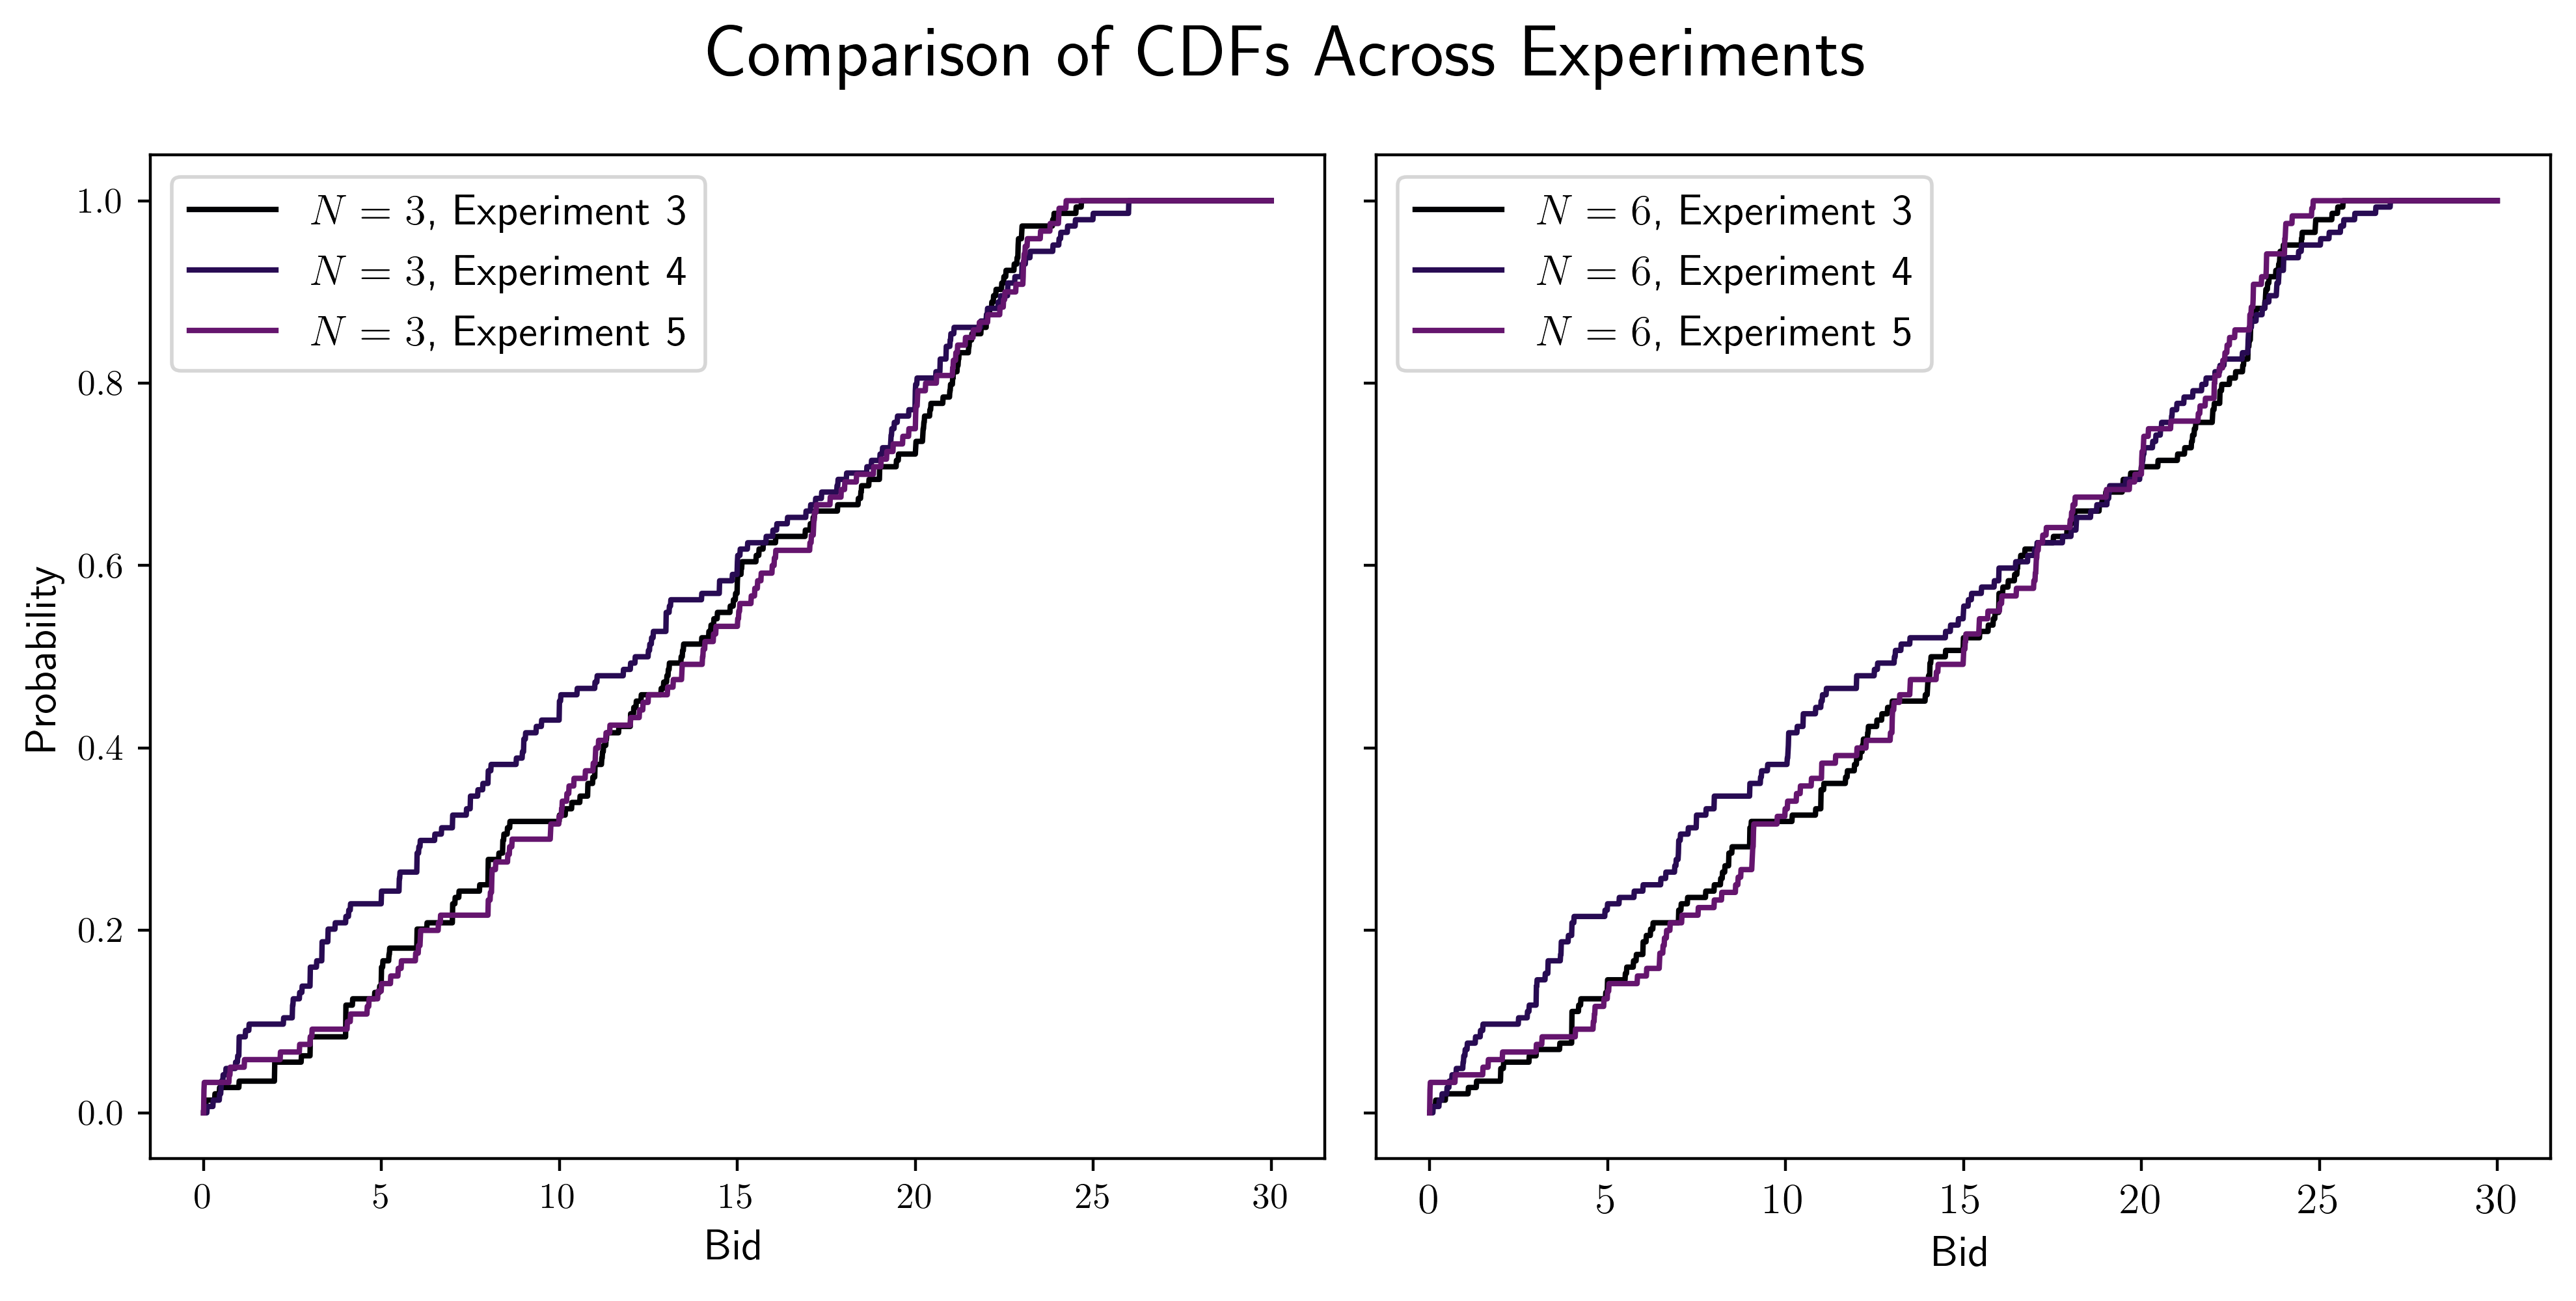

In [17]:
fig4, ax4 = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True, dpi=400, sharey='row')
color = plt.cm.inferno(np.linspace(0, 1, 8))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

support_cdf = np.arange(start=0.0, stop=30.01, step=0.01)
data['Profit_B3'], data['Profit_B6'] = 0., 0.
data['OptError_B3'], data['OptError_B6'] = 0., 0.
cdf_3, cdf_6 = dict(), dict()

# Span over experiments.
for ix, val in enumerate(data.Experiment.unique()):

    # Compute empirical CDFs for N=3 and N=6.
    cdf_3['Exp{}'.format(val)] = return_empirical_cdf(grid=support_cdf, exp=val, num_bid=3)
    cdf_6['Exp{}'.format(val)] = return_empirical_cdf(grid=support_cdf, exp=val, num_bid=6)

    # Compute estimated expected profits.
    exp_index = data['Experiment'] == val
    data.loc[exp_index, 'Profit_B3'] = (data.loc[exp_index,'Value'] - data.loc[exp_index,'BidC3']) * (cdf_3['Exp{}'.format(val)][np.array(data.loc[exp_index, 'BidC3'] * 100, dtype=int)]) ** (3 - 1)
    data.loc[exp_index,'Profit_B6'] = (data.loc[exp_index,'Value'] - data.loc[exp_index,'BidC6']) * (cdf_6['Exp{}'.format(val)][np.array(data.loc[exp_index, 'BidC6'] * 100, dtype=int)]) ** (6 - 1)

    # Compute utility maximizing bids
    util_max_3 = compute_util_max_bid(support_cdf, cdf_3['Exp{}'.format(val)], 3)
    util_max_6 = compute_util_max_bid(support_cdf, cdf_6['Exp{}'.format(val)], 6)

    # Compute optimization errors.
    data.loc[exp_index,'OptError_B3'] = util_max_3[np.array(data.loc[exp_index, 'Value'] * 100, dtype=int)] - data.loc[exp_index,'Profit_B3']
    data.loc[exp_index,'OptError_B6'] = util_max_6[np.array(data.loc[exp_index, 'Value'] * 100, dtype=int)] - data.loc[exp_index,'Profit_B6']

    # Plot CDFs.
    ax4[0].plot(support_cdf, cdf_3['Exp{}'.format(val)], label= r'$N = 3$, Experiment {}'.format(val))
    ax4[1].plot(support_cdf, cdf_6['Exp{}'.format(val)], label= r'$N = 6$, Experiment {}'.format(val))

ax4[0].legend(fontsize=12, ncol=1);
ax4[0].set_ylabel('Probability', fontsize=12);
ax4[0].set_xlabel('Bid', fontsize=12);

ax4[1].legend(fontsize=12, ncol=1);
ax4[1].set_xlabel('Bid', fontsize=12);

fig4.suptitle('Comparison of CDFs Across Experiments', fontsize=20, y=0.99);
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

We see that the distribution of bids varies slightly between the three experiments.

### Part 1 - Question 4

I have Table 1 replicated below in a less refined format. `diff_` refers to the difference in observed and equilibrium Nash bids, `Profit_` refers to the estimated expected profits, and `OptError_` refers to the optimization error of the bidder.

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

data[['diff_BN3', 'diff_BN6', 'Profit_B3',
      'Profit_B6', 'OptError_B3', 'OptError_B6']].describe().to_markdown()

|       | diff_BN3 | diff_BN6 |  Profit_B3  |  Profit_B6  | OptError_B3 | OptError_B6 |
|:-----:|:--------:|:--------:|:-----------:|:-----------:|:-----------:|:-----------:|
| mean  |  2.4441  |  0.6479  |   1.3326    |   0.5791    |   0.3961    |   0.1170    |
|  std  |  1.8633  |  1.0547  |   1.6095    |   1.0559    |   0.4928    |   0.2521    |
|  25%  |  1.0575  |  0.0350  |   0.0804    |   0.0008    |   0.0271    |   0.0002    |
|  50%  |  2.4633  |  0.5583  |   0.6237    |   0.0461    |   0.1914    |   0.0099    |
|  75%  |  3.8333  |  1.4138  |   2.0501    |   0.5682    |   0.6172    |   0.1181    |

## Risk-Neutral Bayes-Nash model

### Part 2 - Questions 1 and 2

In [19]:
# Compute pooled empirical CDF estimates
cdf_3['Pool'] = ECDF(data.BidC3)
cdf_6['Pool'] = ECDF(data.BidC6)

In [20]:
pdf_3, pdf_6 = dict(), dict()

# Compute experiment specific PDF estimates using Gaussian kernel.

for ix, val in enumerate(data.Experiment.unique()):

    kernel3 = kernel_est(endog=data.query('Experiment == {}'.format(val))['BidC3']).fit(kernel='gau', bw='silverman')
    kernel6 = kernel_est(endog=data.query('Experiment == {}'.format(val))['BidC6']).fit(kernel='gau', bw='silverman')

    # Compute empirical CDFs for N=3 and N=6.
    pdf_3['Exp{}'.format(val)] = kernel3
    pdf_6['Exp{}'.format(val)] = kernel6

kernel3 = kernel_est(endog=data['BidC3']).fit(kernel='gau', bw='silverman')
kernel6 = kernel_est(endog=data['BidC6']).fit(kernel='gau', bw='silverman')

pdf_3['Pool'] = kernel3
pdf_6['Pool'] = kernel6

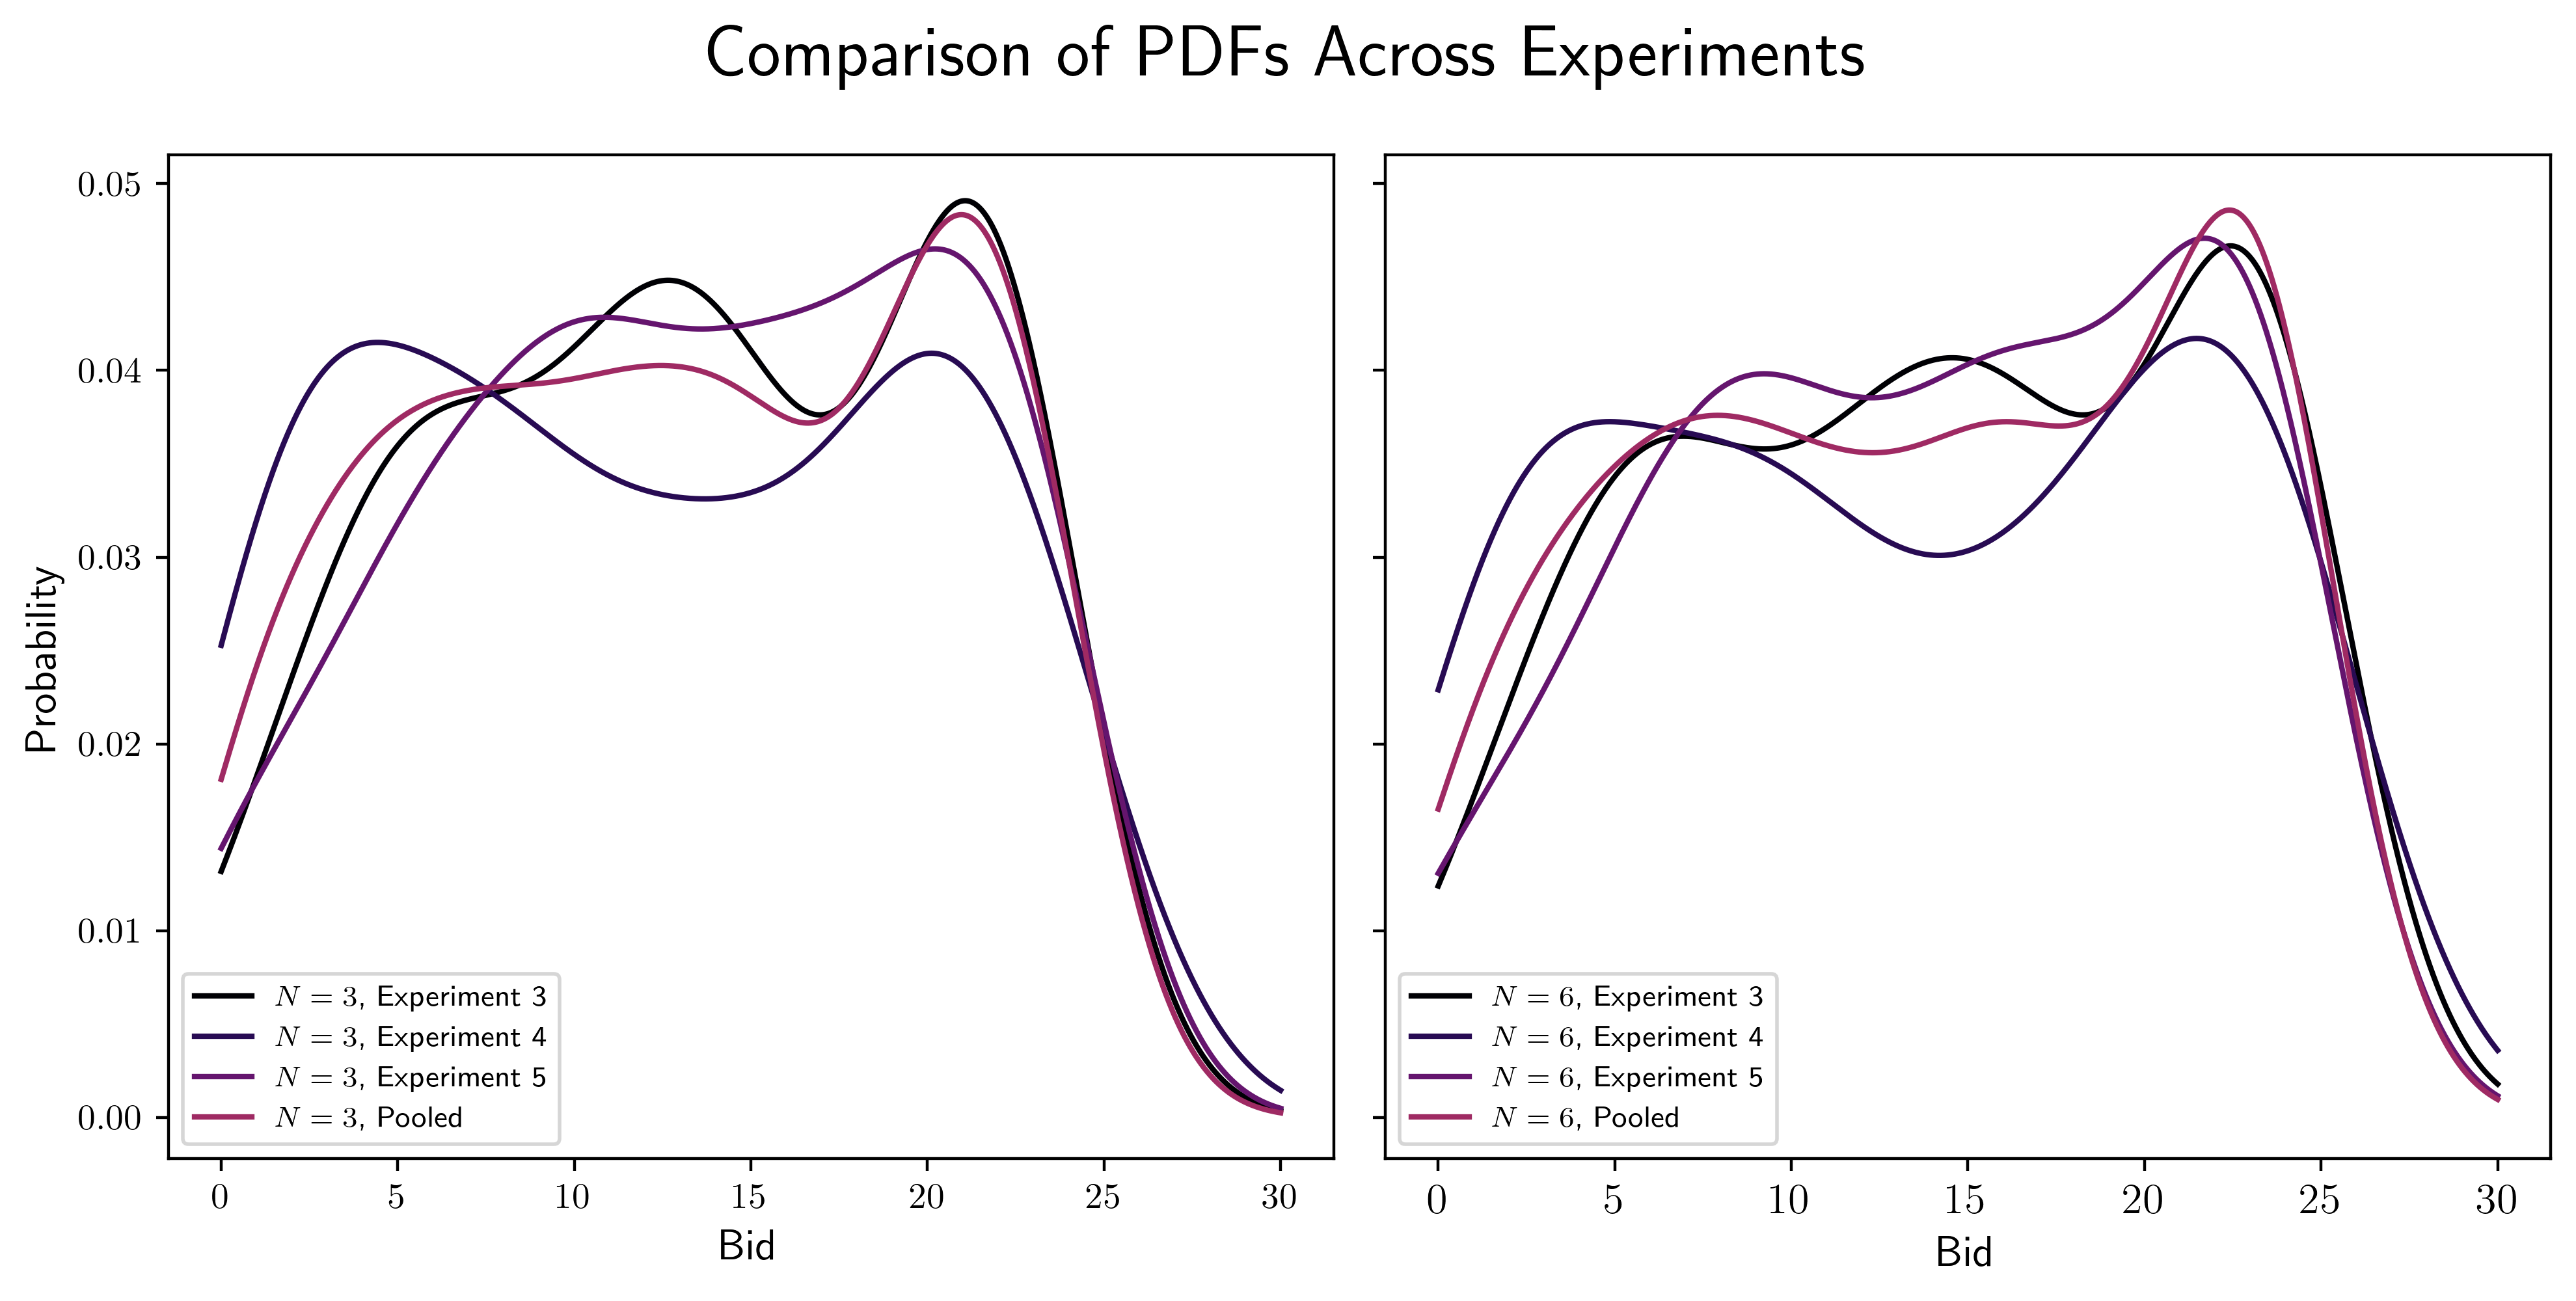

In [21]:
fig5, ax5 = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True, dpi=400, sharey='row')
color = plt.cm.inferno(np.linspace(0, 1, 8))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

# Span over experiments.
for ix, val in enumerate(data.Experiment.unique()):

    # Plot CDFs.
    ax5[0].plot(support_cdf, pdf_3['Exp{}'.format(val)].evaluate(support_cdf),
                label= r'$N = 3$, Experiment {}'.format(val))
    ax5[1].plot(support_cdf, pdf_6['Exp{}'.format(val)].evaluate(support_cdf),
                label= r'$N = 6$, Experiment {}'.format(val))

ax5[0].plot(support_cdf, pdf_3['Pool'].evaluate(support_cdf),
            label= r'$N = 3$, Pooled')
ax5[1].plot(support_cdf, pdf_6['Pool'].evaluate(support_cdf),
            label= r'$N = 6$, Pooled')

ax5[0].legend(fontsize=8, ncol=1, loc=3);
ax5[0].set_ylabel('Probability', fontsize=12);
ax5[0].set_xlabel('Bid', fontsize=12);

ax5[1].legend(fontsize=8, ncol=1, loc=3);
ax5[1].set_xlabel('Bid', fontsize=12);

fig5.suptitle('Comparison of PDFs Across Experiments', fontsize=20, y=0.99);
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

In [22]:
data['EstVal_3_RN'] = data['BidC3'] + \
                   cdf_3['Pool'](data['BidC3']) / \
                   (2 * pdf_3['Pool'].evaluate(np.array(data['BidC3'])))

data['EstVal_6_RN'] = data['BidC6'] + \
                   cdf_6['Pool'](data['BidC6']) / \
                   (5 * pdf_6['Pool'].evaluate(np.array(data['BidC6'])))

data['EstVal_3_E3_RN'] = data['BidC3'] + \
                   cdf_3['Exp3'][np.array(data['BidC3'] * 100, dtype=int)] / \
                   (2 * pdf_3['Exp3'].evaluate(np.array(data['BidC3'])))

data['EstVal_6_E3_RN'] = data['BidC6'] + \
                   cdf_6['Exp3'][np.array(data['BidC6'] * 100, dtype=int)] / \
                   (5 * pdf_6['Exp3'].evaluate(np.array(data['BidC6'])))

data['EstVal_3_E4_RN'] = data['BidC3'] + \
                      cdf_3['Exp4'][np.array(data['BidC3'] * 100, dtype=int)] / \
                      (2 * pdf_3['Exp4'].evaluate(np.array(data['BidC3'])))

data['EstVal_6_E4_RN'] = data['BidC6'] + \
                      cdf_6['Exp4'][np.array(data['BidC6'] * 100, dtype=int)] / \
                      (5 * pdf_6['Exp4'].evaluate(np.array(data['BidC6'])))

data['EstVal_3_E5_RN'] = data['BidC3'] + \
                      cdf_3['Exp5'][np.array(data['BidC3'] * 100, dtype=int)] / \
                      (2 * pdf_3['Exp5'].evaluate(np.array(data['BidC3'])))

data['EstVal_6_E5_RN'] = data['BidC6'] + \
                      cdf_6['Exp5'][np.array(data['BidC6'] * 100, dtype=int)] / \
                      (5 * pdf_6['Exp5'].evaluate(np.array(data['BidC6'])))

### Part 2 - Question 3

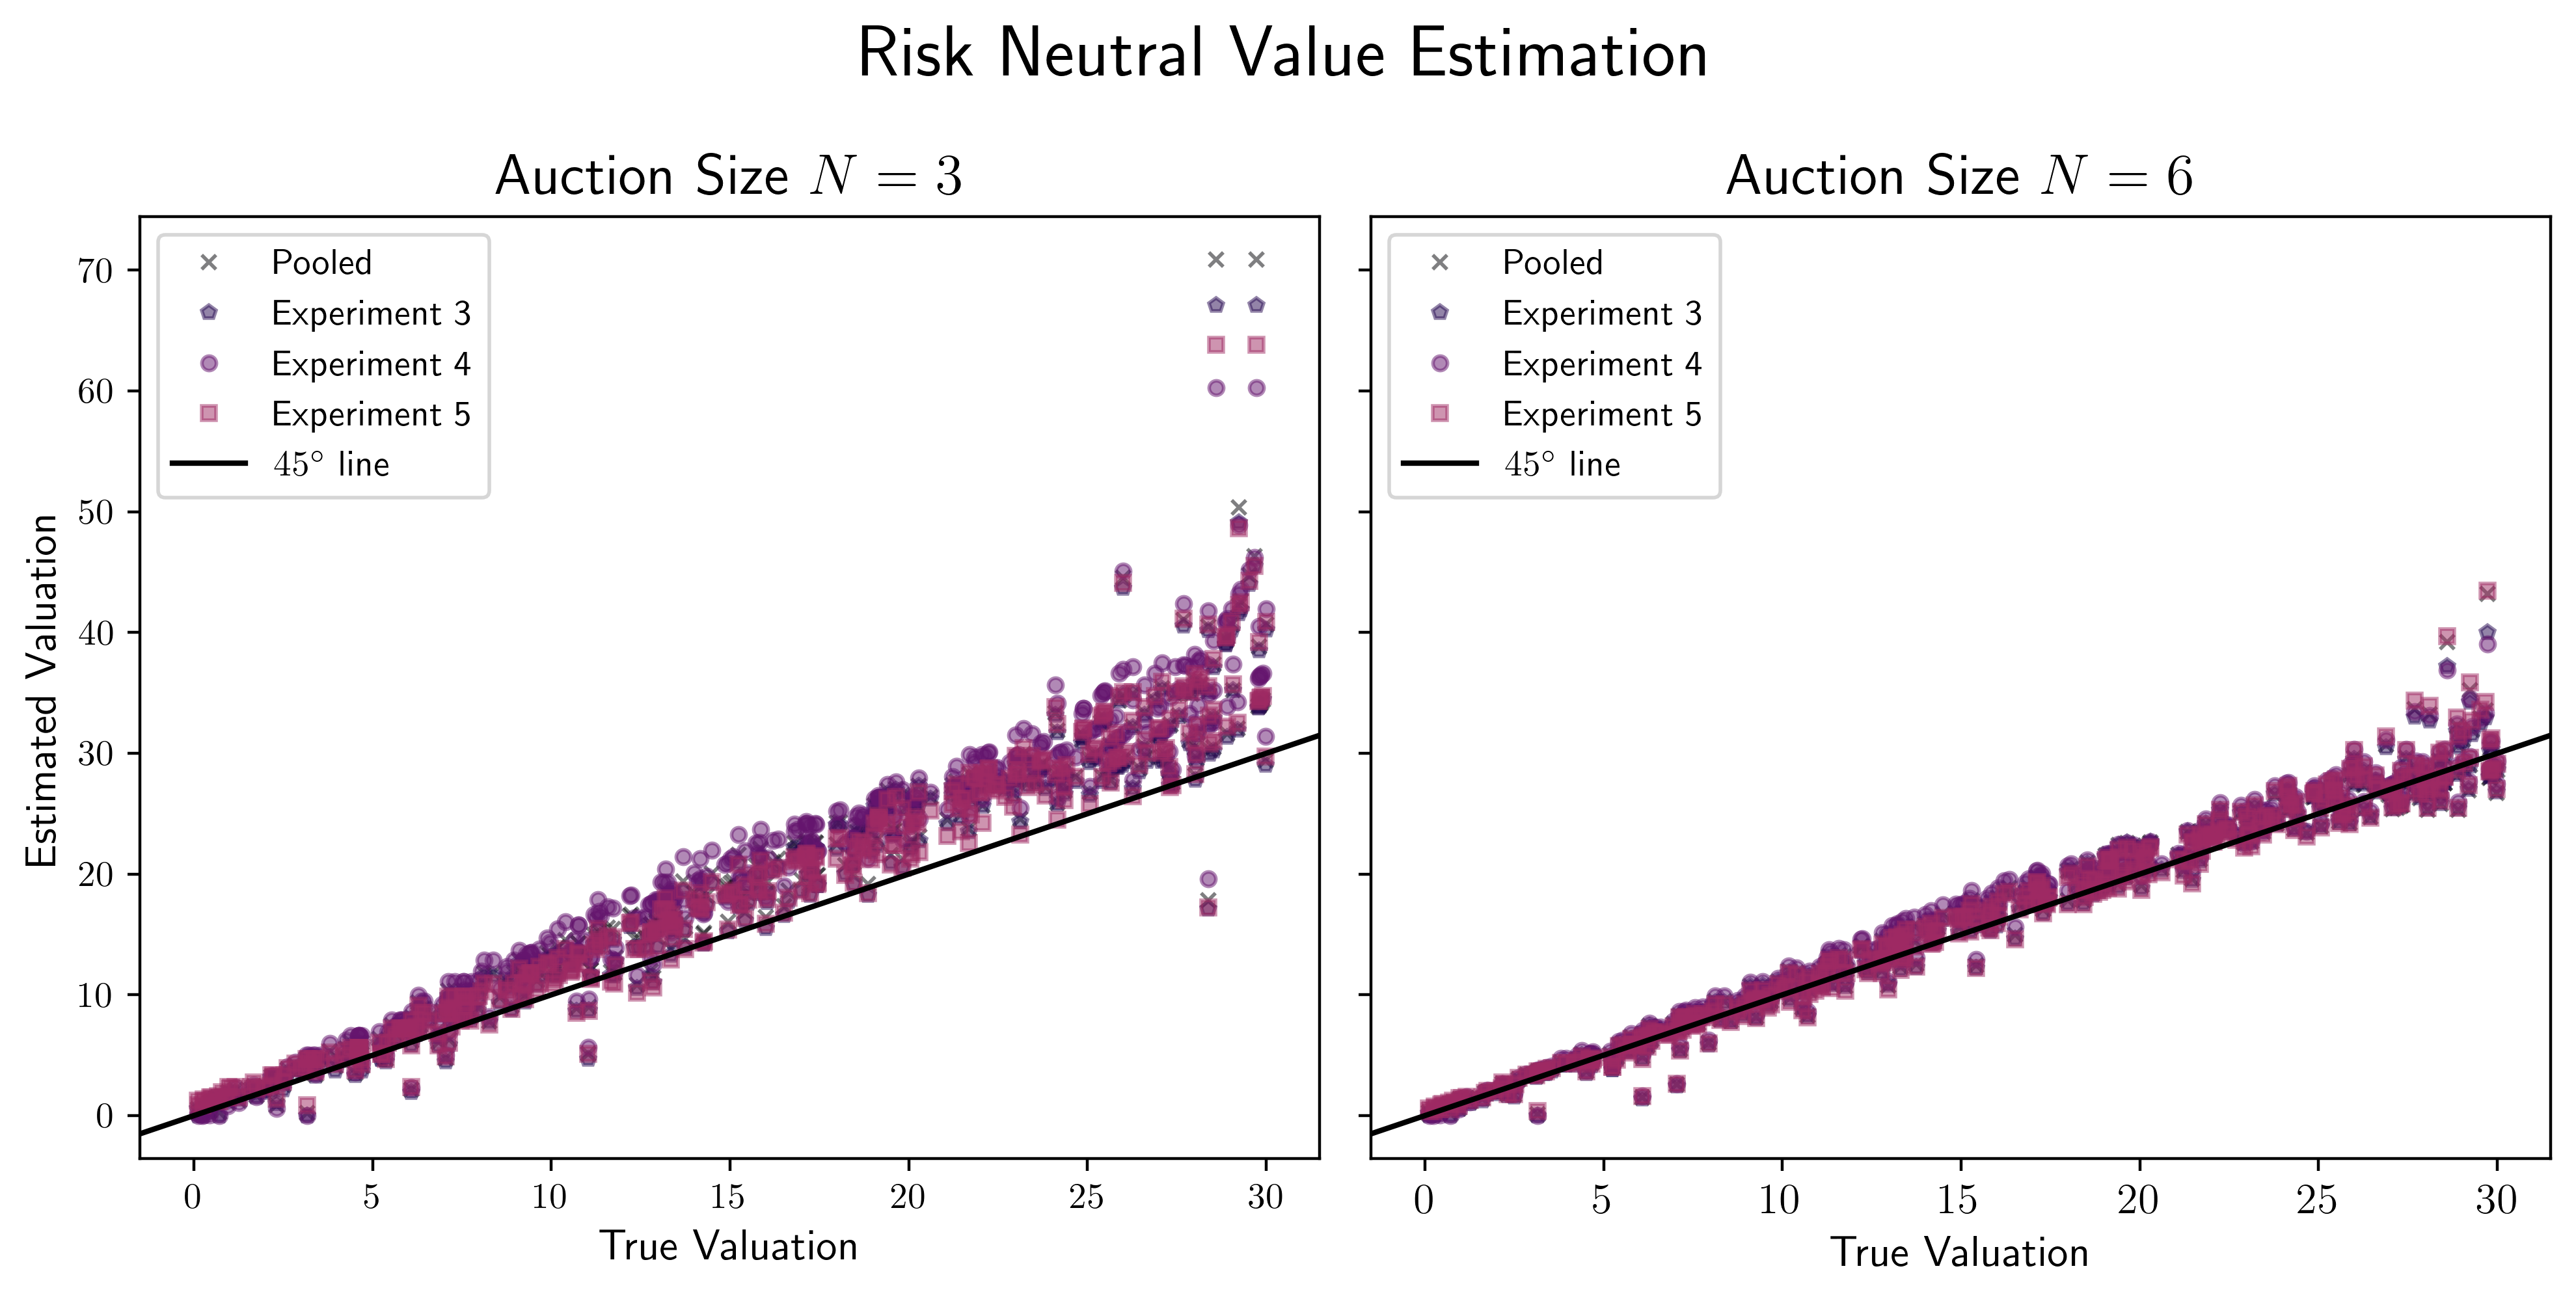

In [23]:
fig6, ax6 = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True, dpi=400, sharey='row')
color = plt.cm.inferno(np.linspace(0.1, 1, 8))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

ax6[0].plot(data.Value, data.EstVal_3_RN,  label= r'Pooled', marker='x', linestyle='', markersize=4, alpha=0.5)
ax6[0].plot(data.Value, data.EstVal_3_E3_RN,  label= r'Experiment 3', marker='p', linestyle='', markersize=4, alpha=0.5)
ax6[0].plot(data.Value, data.EstVal_3_E4_RN,  label= r'Experiment 4', marker='o', linestyle='', markersize=4, alpha=0.5)
ax6[0].plot(data.Value, data.EstVal_3_E5_RN,  label= r'Experiment 5', marker='s', linestyle='', markersize=4, alpha=0.5)

ax6[0].axline([0, 0], [1, 1], label= r'$45^\circ$ line', color='k')

ax6[1].plot(data.Value, data.EstVal_6_RN,  label= r'Pooled', marker='x', linestyle='', markersize=4, alpha=0.5)
ax6[1].plot(data.Value, data.EstVal_6_E3_RN,  label= r'Experiment 3', marker='p', linestyle='', markersize=4, alpha=0.5)
ax6[1].plot(data.Value, data.EstVal_6_E4_RN,  label= r'Experiment 4', marker='o', linestyle='', markersize=4, alpha=0.5)
ax6[1].plot(data.Value, data.EstVal_6_E5_RN,  label= r'Experiment 5', marker='s', linestyle='', markersize=4, alpha=0.5)

ax6[1].axline([0, 0], [1, 1], label= r'$45^\circ$ line', color='k')

ax6[0].legend(fontsize=10, ncol=1, loc=2);
ax6[0].set_ylabel('Estimated Valuation', fontsize=12);
ax6[0].set_xlabel('True Valuation', fontsize=12);
ax6[0].set_title(r'Auction Size $N = 3$', fontsize=16);

ax6[1].legend(fontsize=10, ncol=1, loc=2);
ax6[1].set_xlabel('True Valuation', fontsize=12);
ax6[1].set_title(r'Auction Size $N = 6$', fontsize=16);

fig6.suptitle('Risk Neutral Value Estimation', fontsize=20, y=0.99);
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

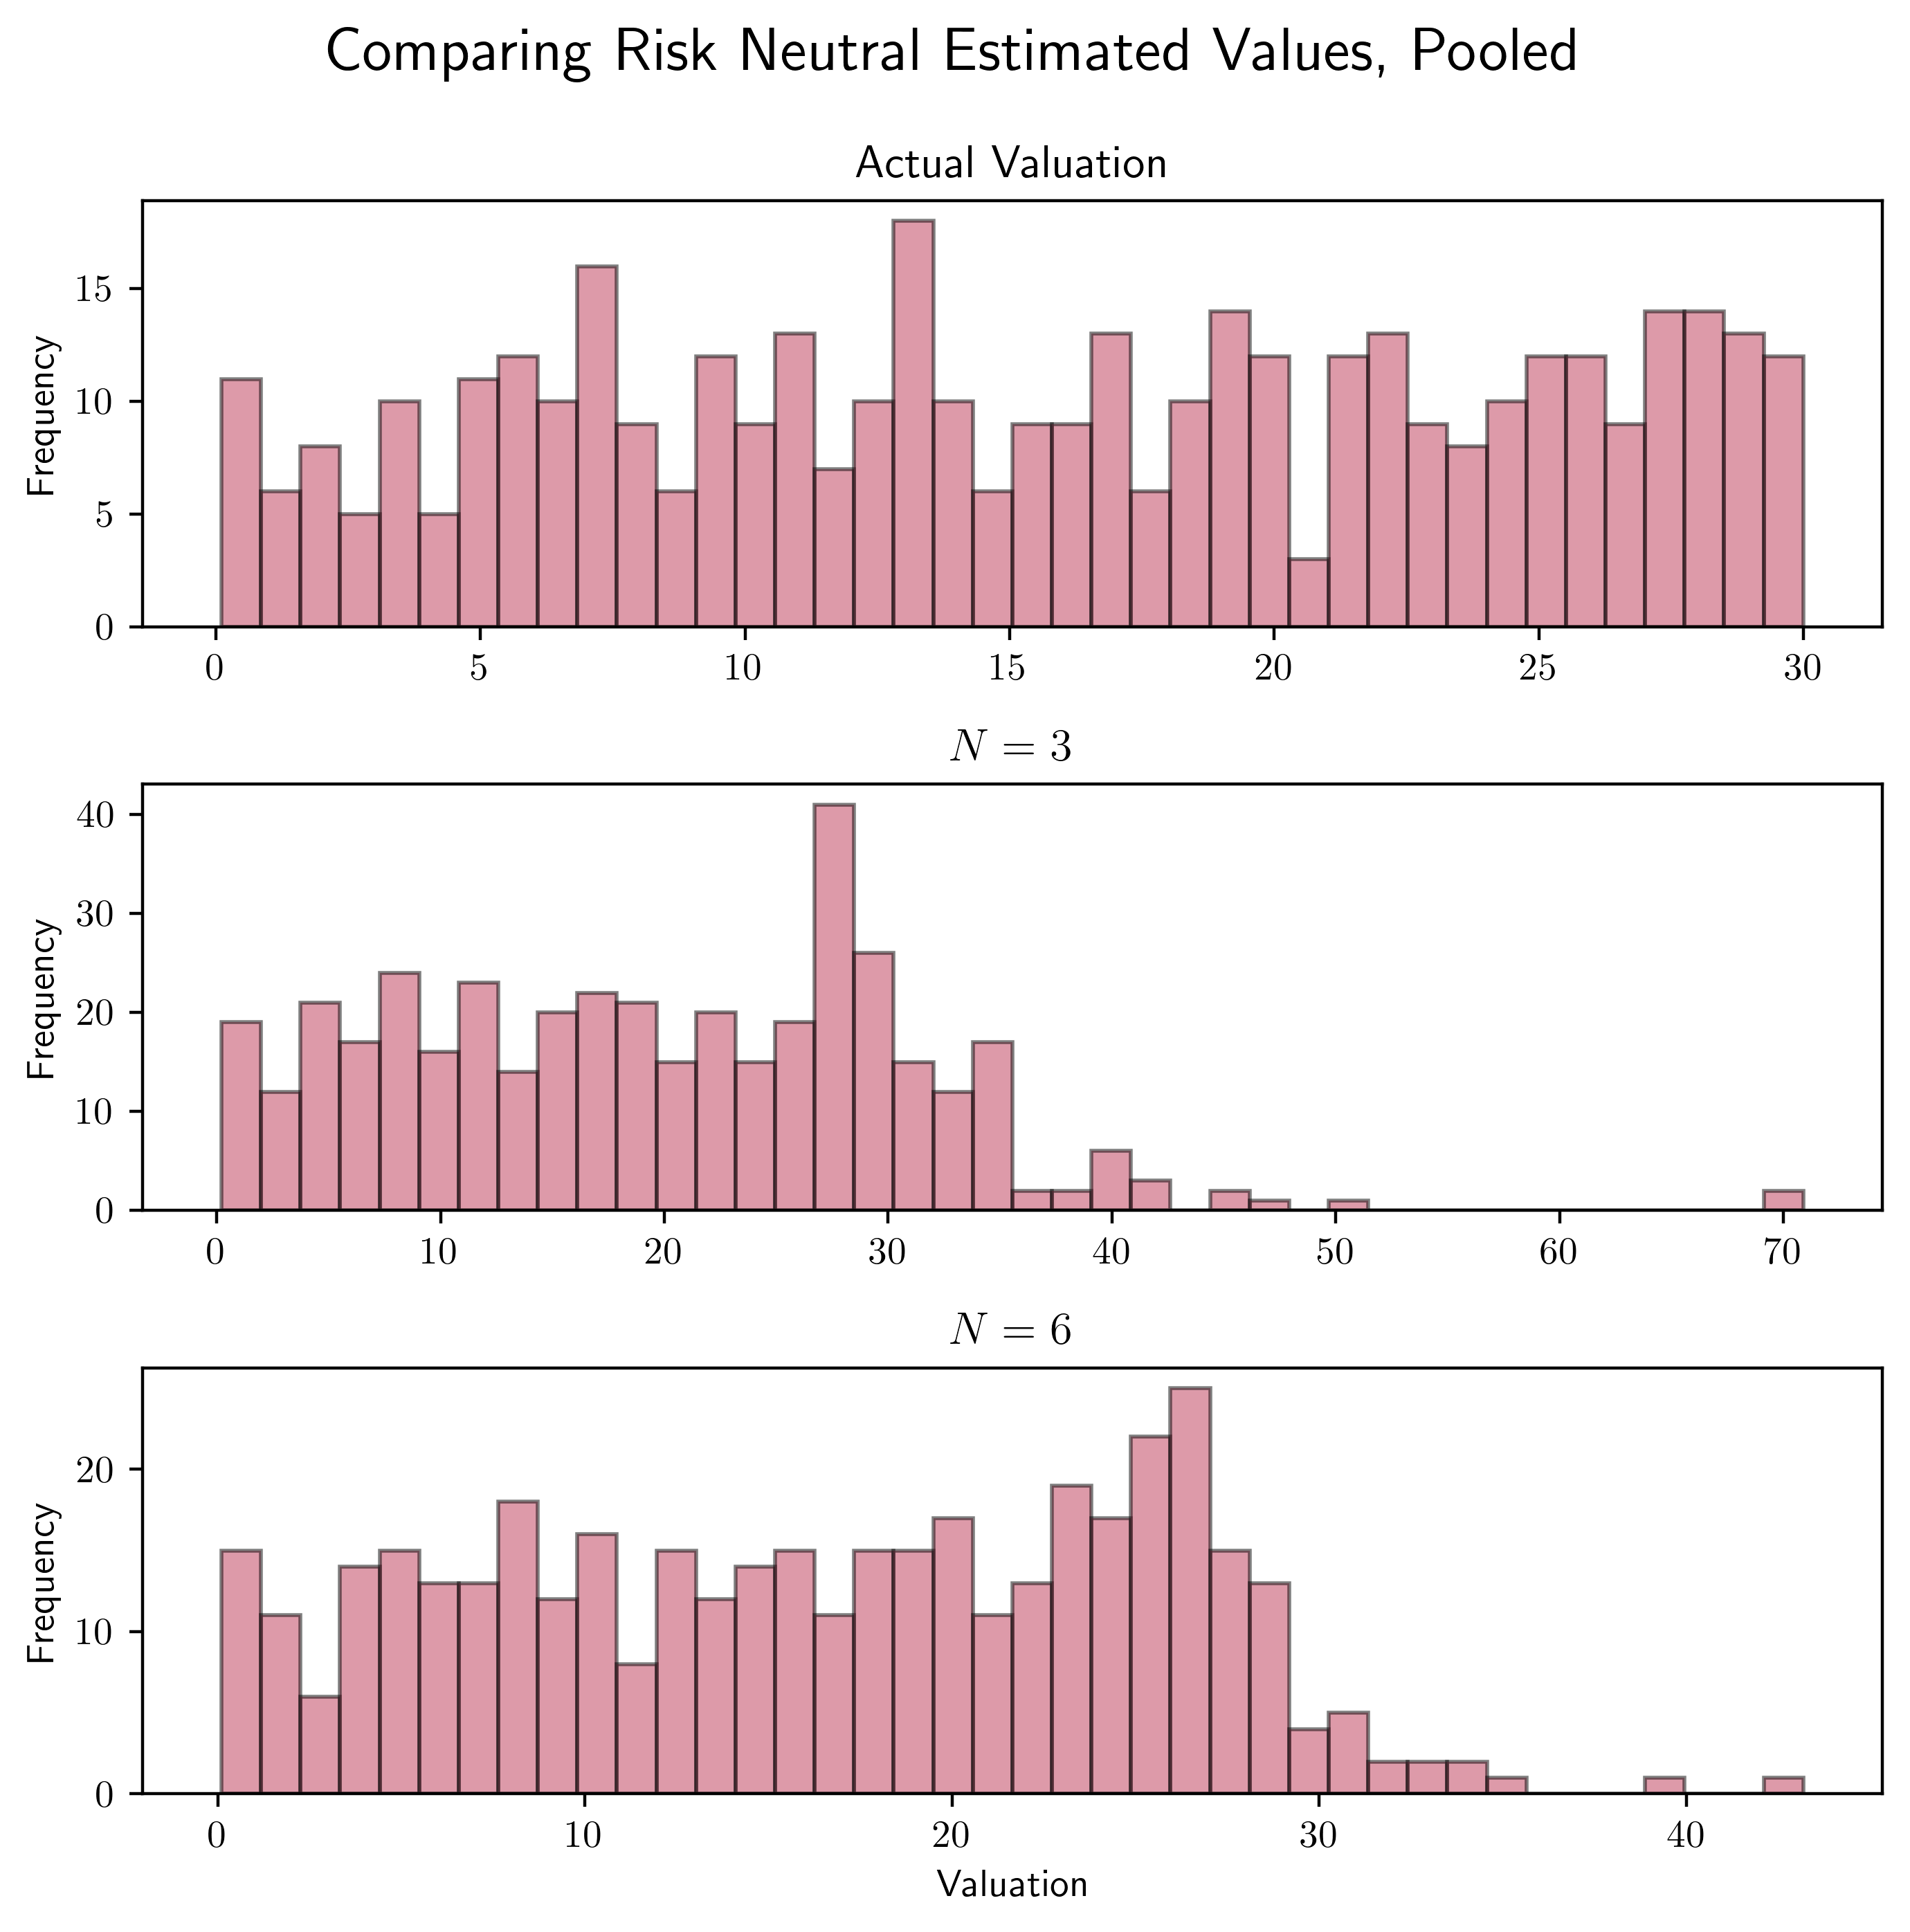

In [26]:
fig7, ax7 = plt.subplots(3, 1, figsize=(7, 7), tight_layout=True, dpi=400)
color = plt.cm.inferno(np.linspace(0.5, 1, 8))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

ax7[0].hist(data.Value, 40, alpha=0.5, histtype='bar', ec='black');
ax7[0].set_title('Actual Valuation', fontsize=12)
ax7[0].set_ylabel(r'Frequency', fontsize=10);

ax7[1].hist(data.EstVal_3_RN, 40, alpha=0.5, label=r'Pooled',
            histtype='bar', ec='black');
ax7[1].set_title('$N = 3$', fontsize=12);
ax7[1].set_ylabel(r'Frequency', fontsize=10);

ax7[2].hist(data.EstVal_6_RN, 40, alpha=0.5, label=r'Pooled',
              histtype='bar', ec='black');
ax7[2].set_title('$N = 6$', fontsize=12)
ax7[2].set_xlabel(r'Valuation', fontsize=10);
ax7[2].set_ylabel(r'Frequency', fontsize=10);

fig7.suptitle('Comparing Risk Neutral Estimated Values, Pooled', fontsize=16, y=0.99);

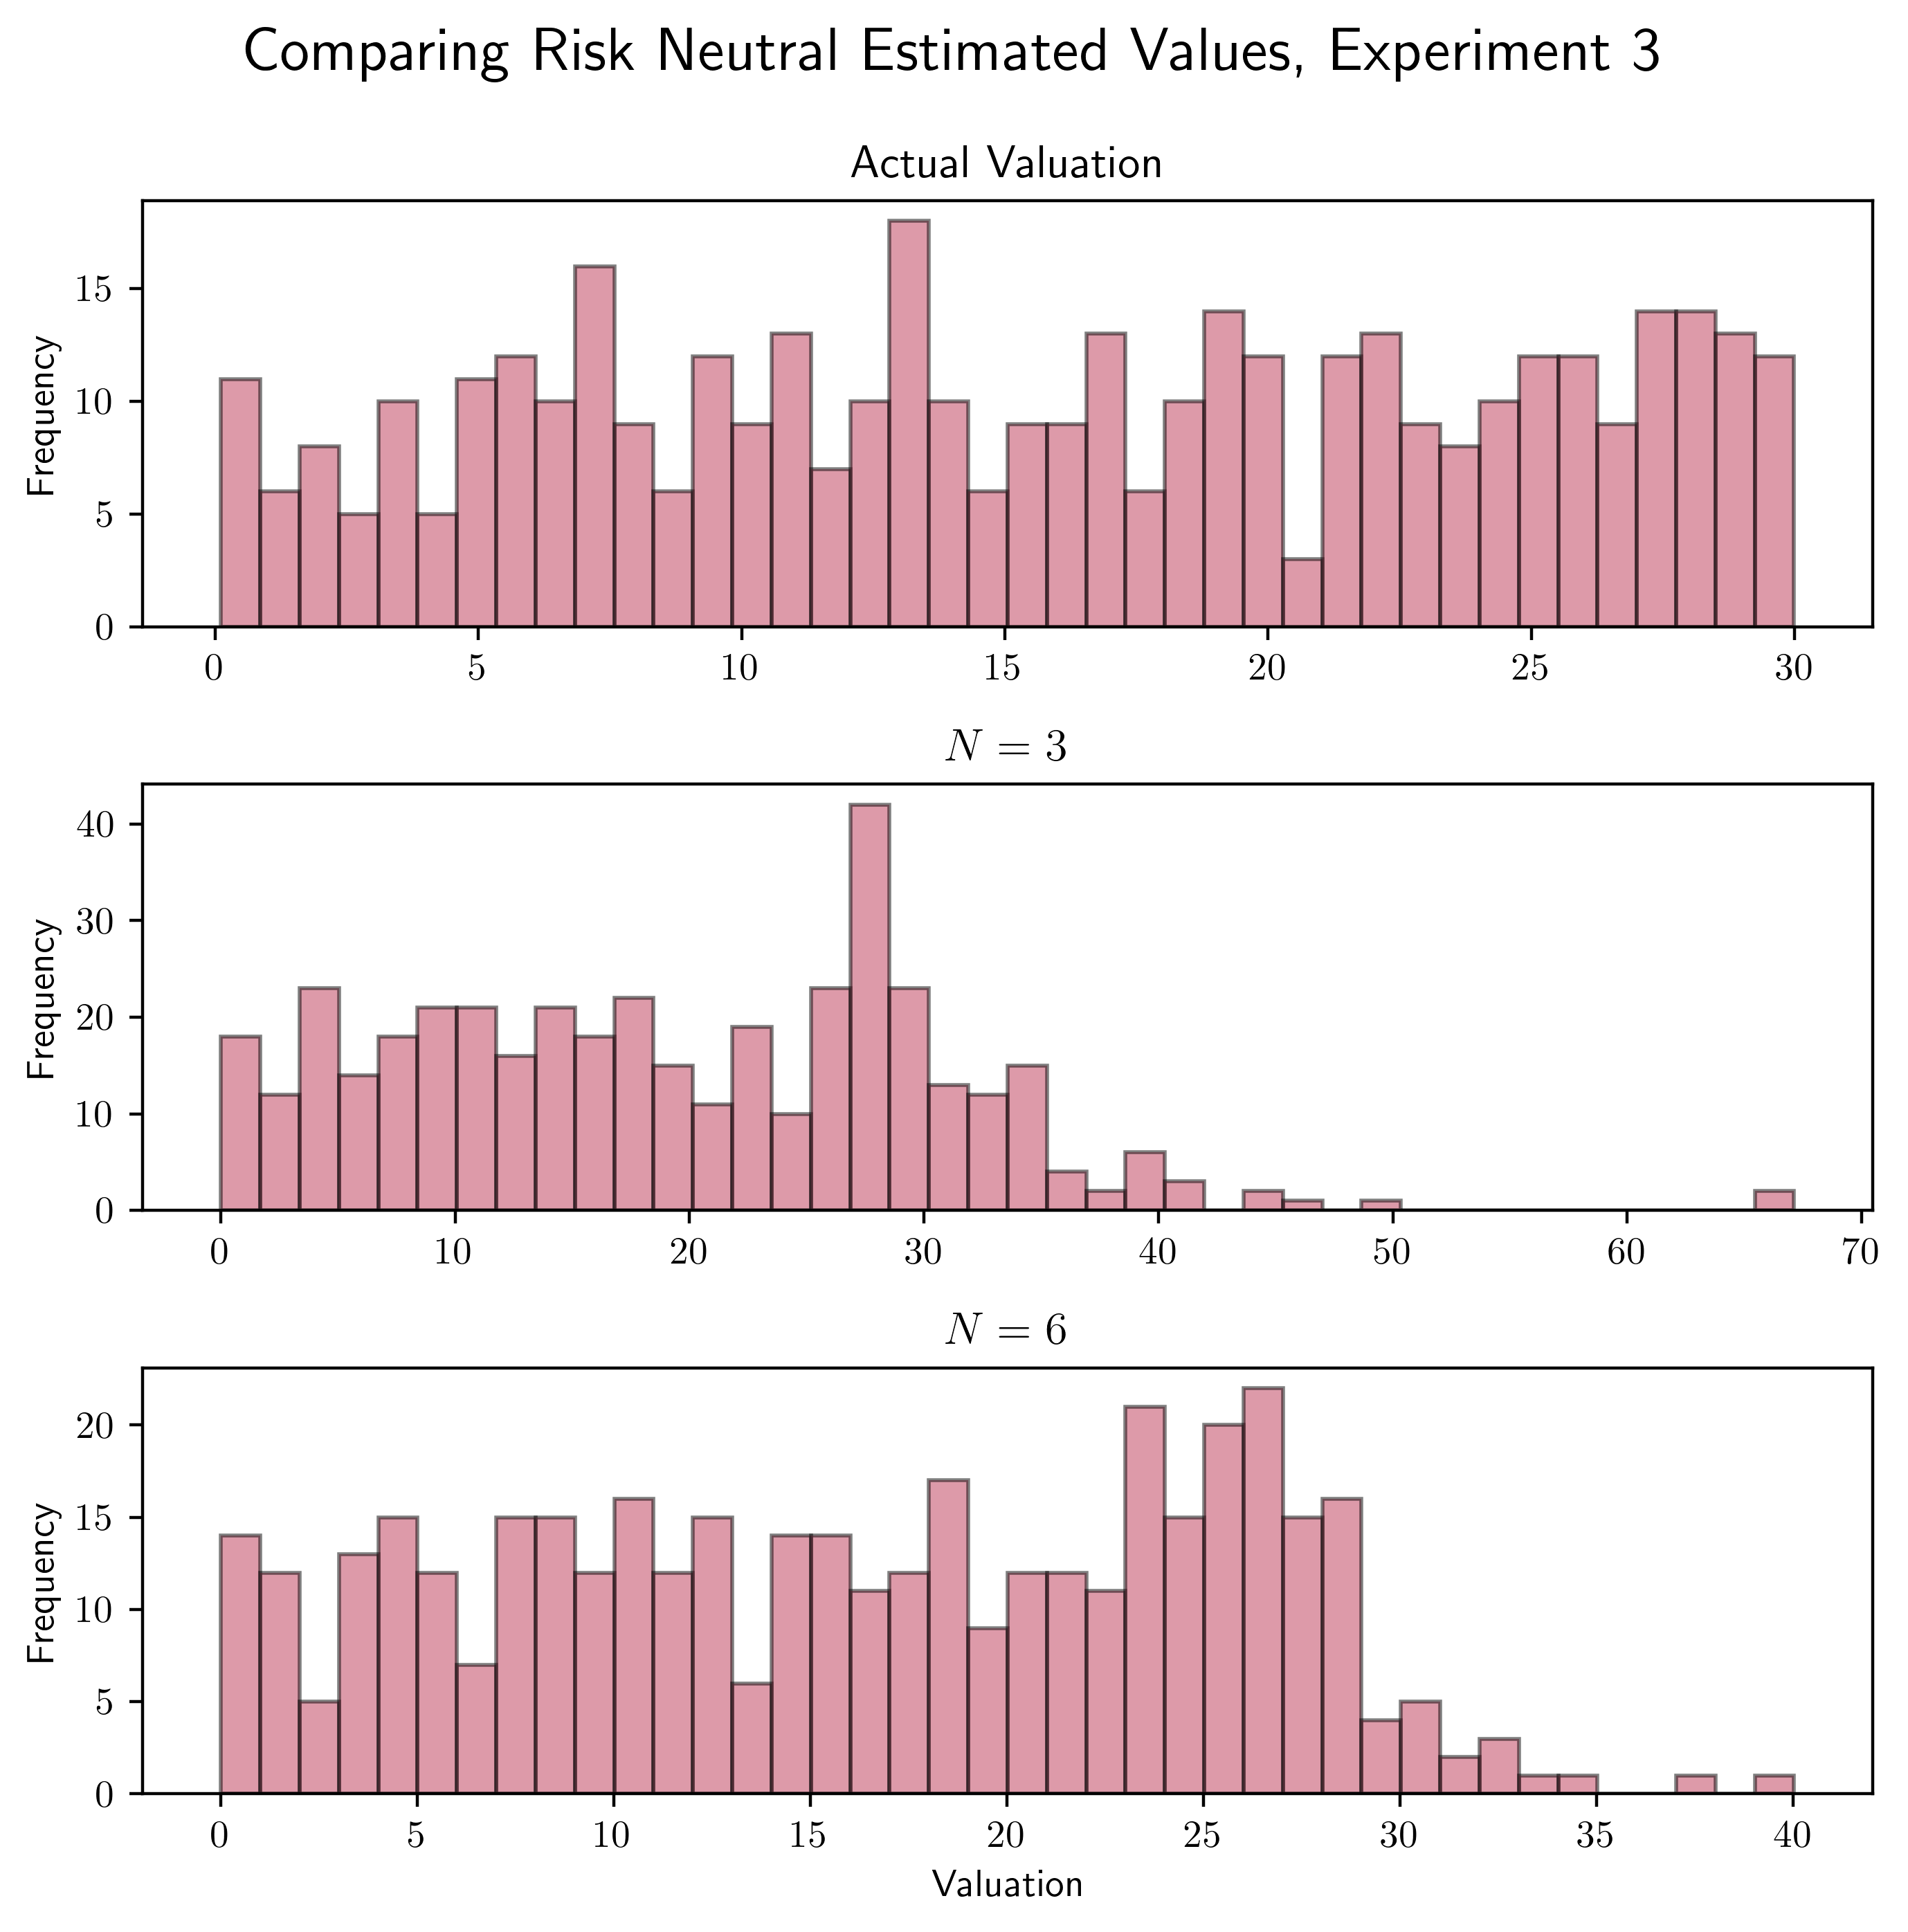

In [25]:
fig7, ax7 = plt.subplots(3, 1, figsize=(7, 7), tight_layout=True, dpi=400)
color = plt.cm.inferno(np.linspace(0.5, 1, 8))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

ax7[0].hist(data.Value, 40, alpha=0.5, histtype='bar', ec='black');
ax7[0].set_title('Actual Valuation', fontsize=12)
ax7[0].set_ylabel(r'Frequency', fontsize=10);

ax7[1].hist(data.EstVal_3_E3_RN, 40, alpha=0.5, label=r'Pooled',
            histtype='bar', ec='black');
ax7[1].set_title('$N = 3$', fontsize=12);
ax7[1].set_ylabel(r'Frequency', fontsize=10);

ax7[2].hist(data.EstVal_6_E3_RN, 40, alpha=0.5, label=r'Pooled',
            histtype='bar', ec='black');
ax7[2].set_title('$N = 6$', fontsize=12)
ax7[2].set_xlabel(r'Valuation', fontsize=10);
ax7[2].set_ylabel(r'Frequency', fontsize=10);

fig7.suptitle('Comparing Risk Neutral Estimated Values, Experiment 3', fontsize=16, y=0.99);

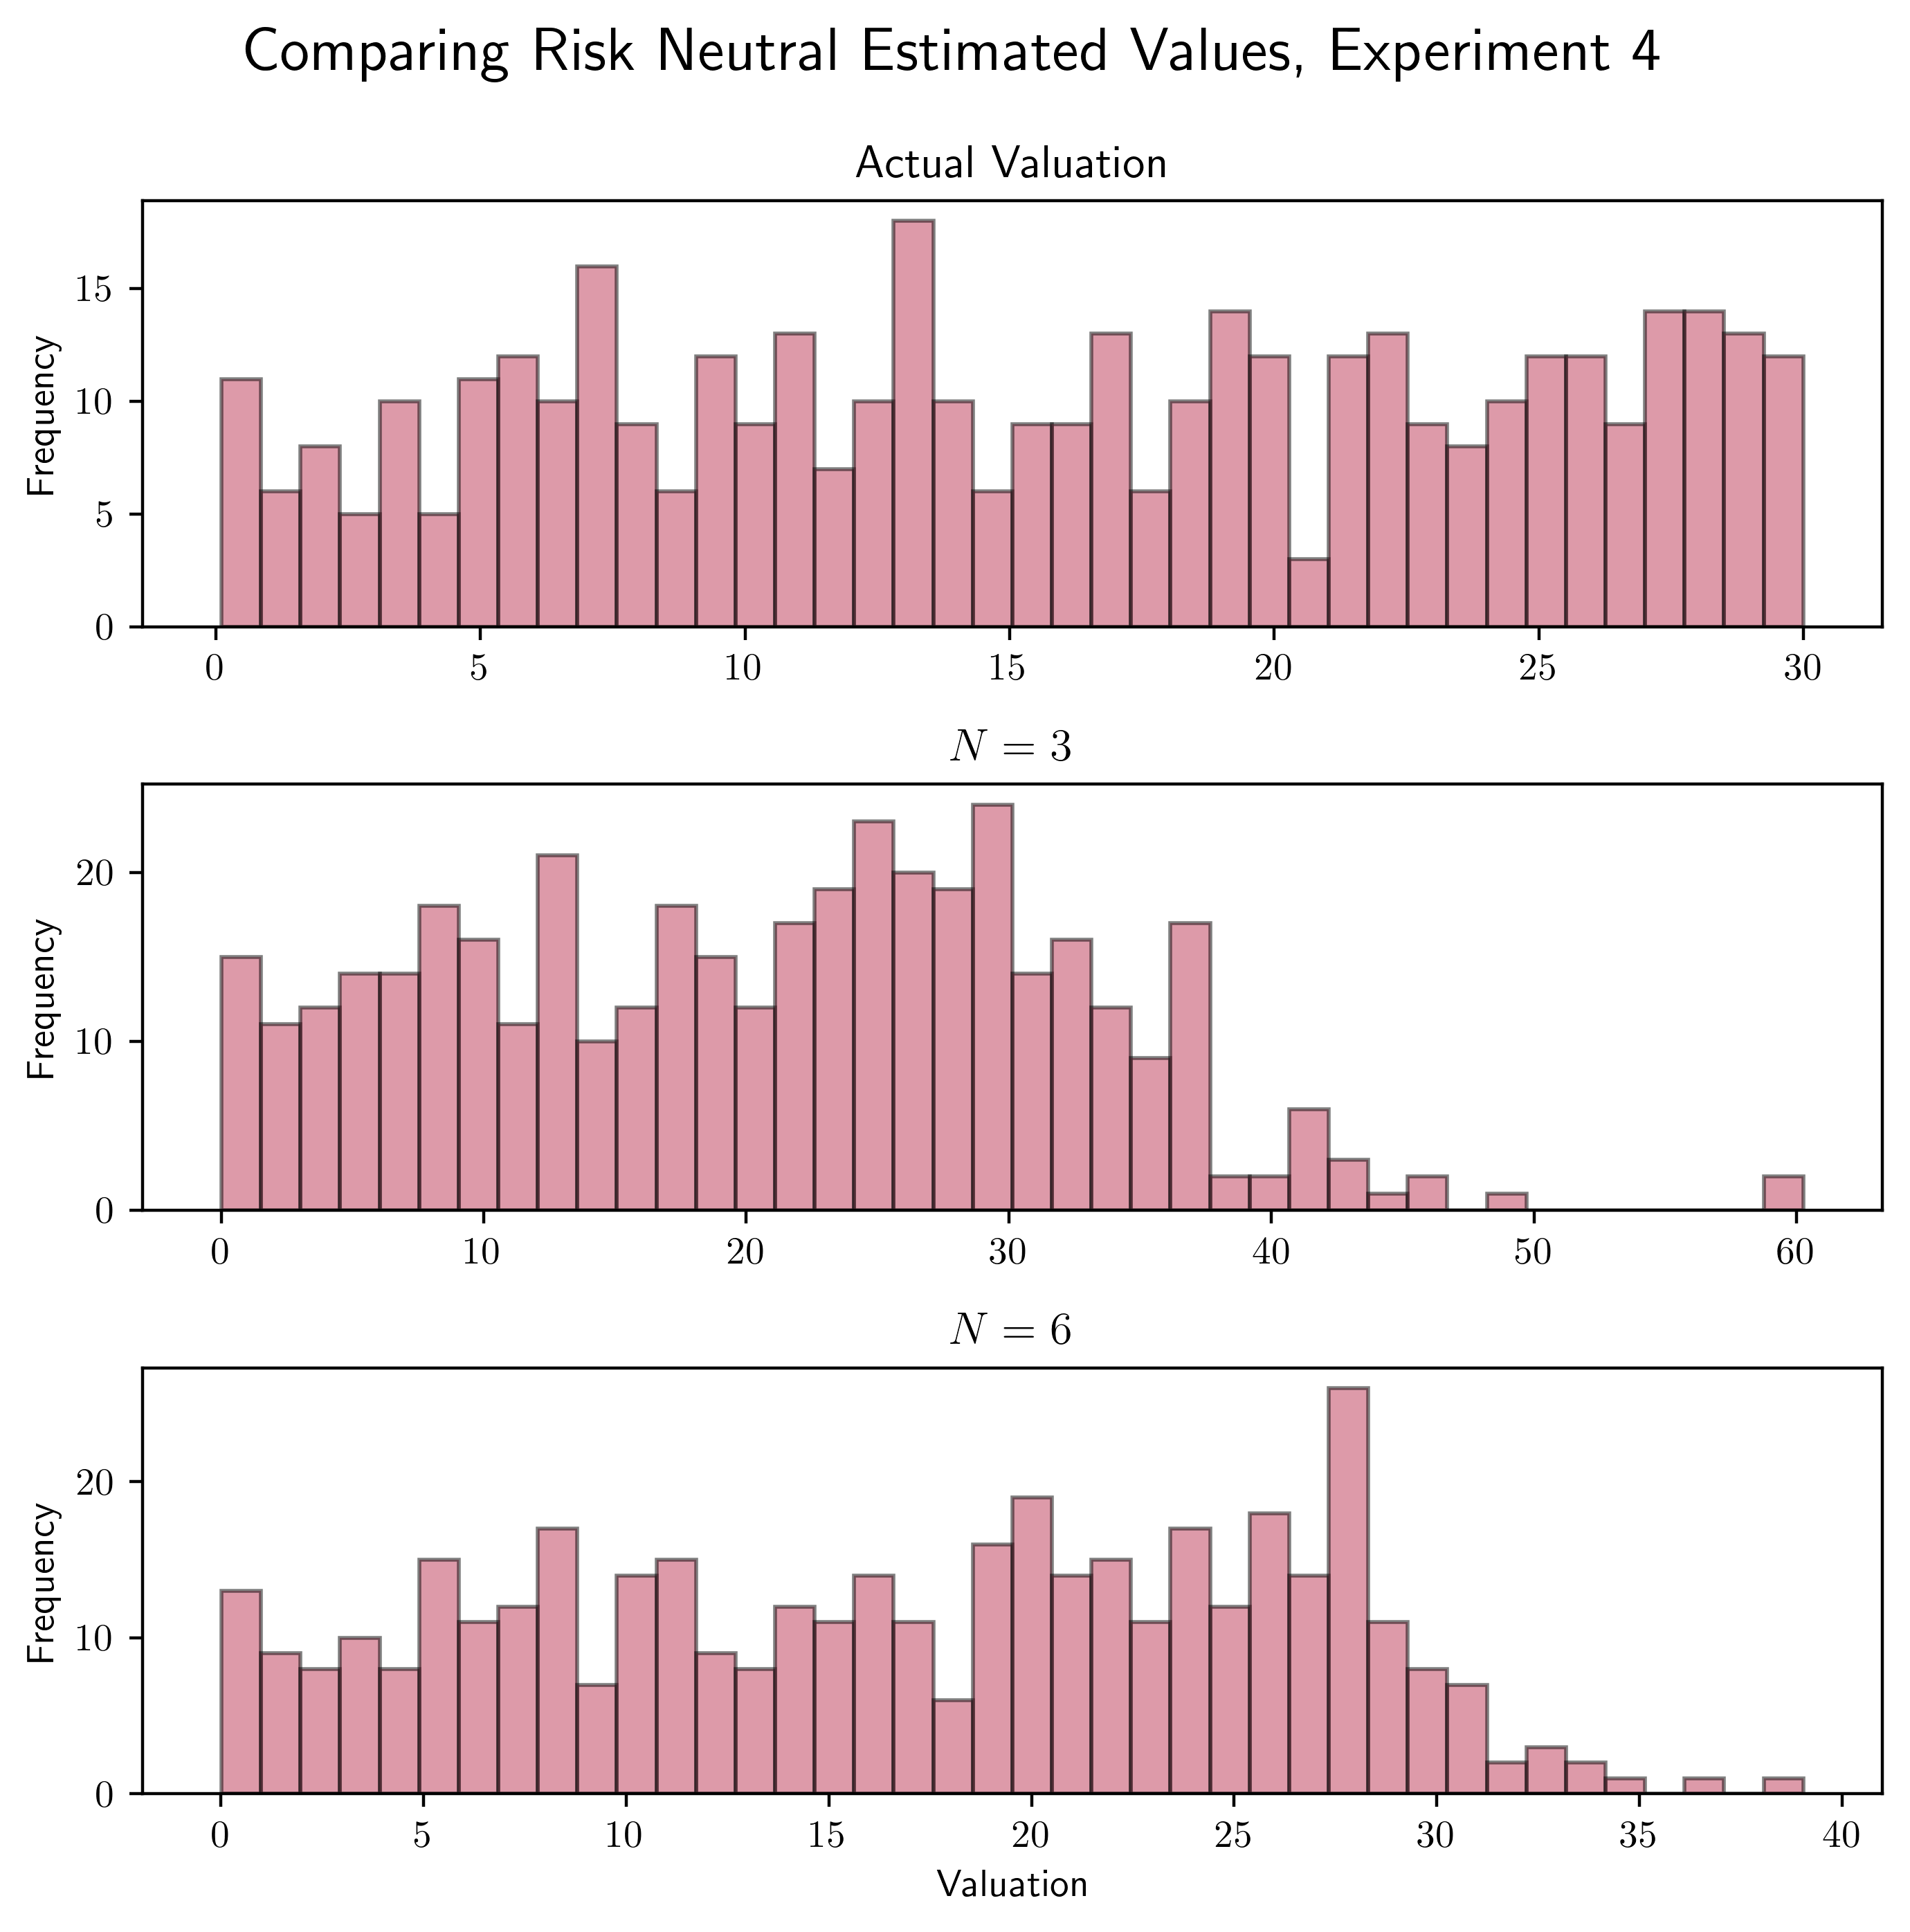

In [27]:
fig7, ax7 = plt.subplots(3, 1, figsize=(7, 7), tight_layout=True, dpi=400)
color = plt.cm.inferno(np.linspace(0.5, 1, 8))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

ax7[0].hist(data.Value, 40, alpha=0.5, histtype='bar', ec='black');
ax7[0].set_title('Actual Valuation', fontsize=12)
ax7[0].set_ylabel(r'Frequency', fontsize=10);

ax7[1].hist(data.EstVal_3_E4_RN, 40, alpha=0.5, label=r'Pooled',
            histtype='bar', ec='black');
ax7[1].set_title('$N = 3$', fontsize=12);
ax7[1].set_ylabel(r'Frequency', fontsize=10);

ax7[2].hist(data.EstVal_6_E4_RN, 40, alpha=0.5, label=r'Pooled',
            histtype='bar', ec='black');
ax7[2].set_title('$N = 6$', fontsize=12)
ax7[2].set_xlabel(r'Valuation', fontsize=10);
ax7[2].set_ylabel(r'Frequency', fontsize=10);

fig7.suptitle('Comparing Risk Neutral Estimated Values, Experiment 4', fontsize=16, y=0.99);

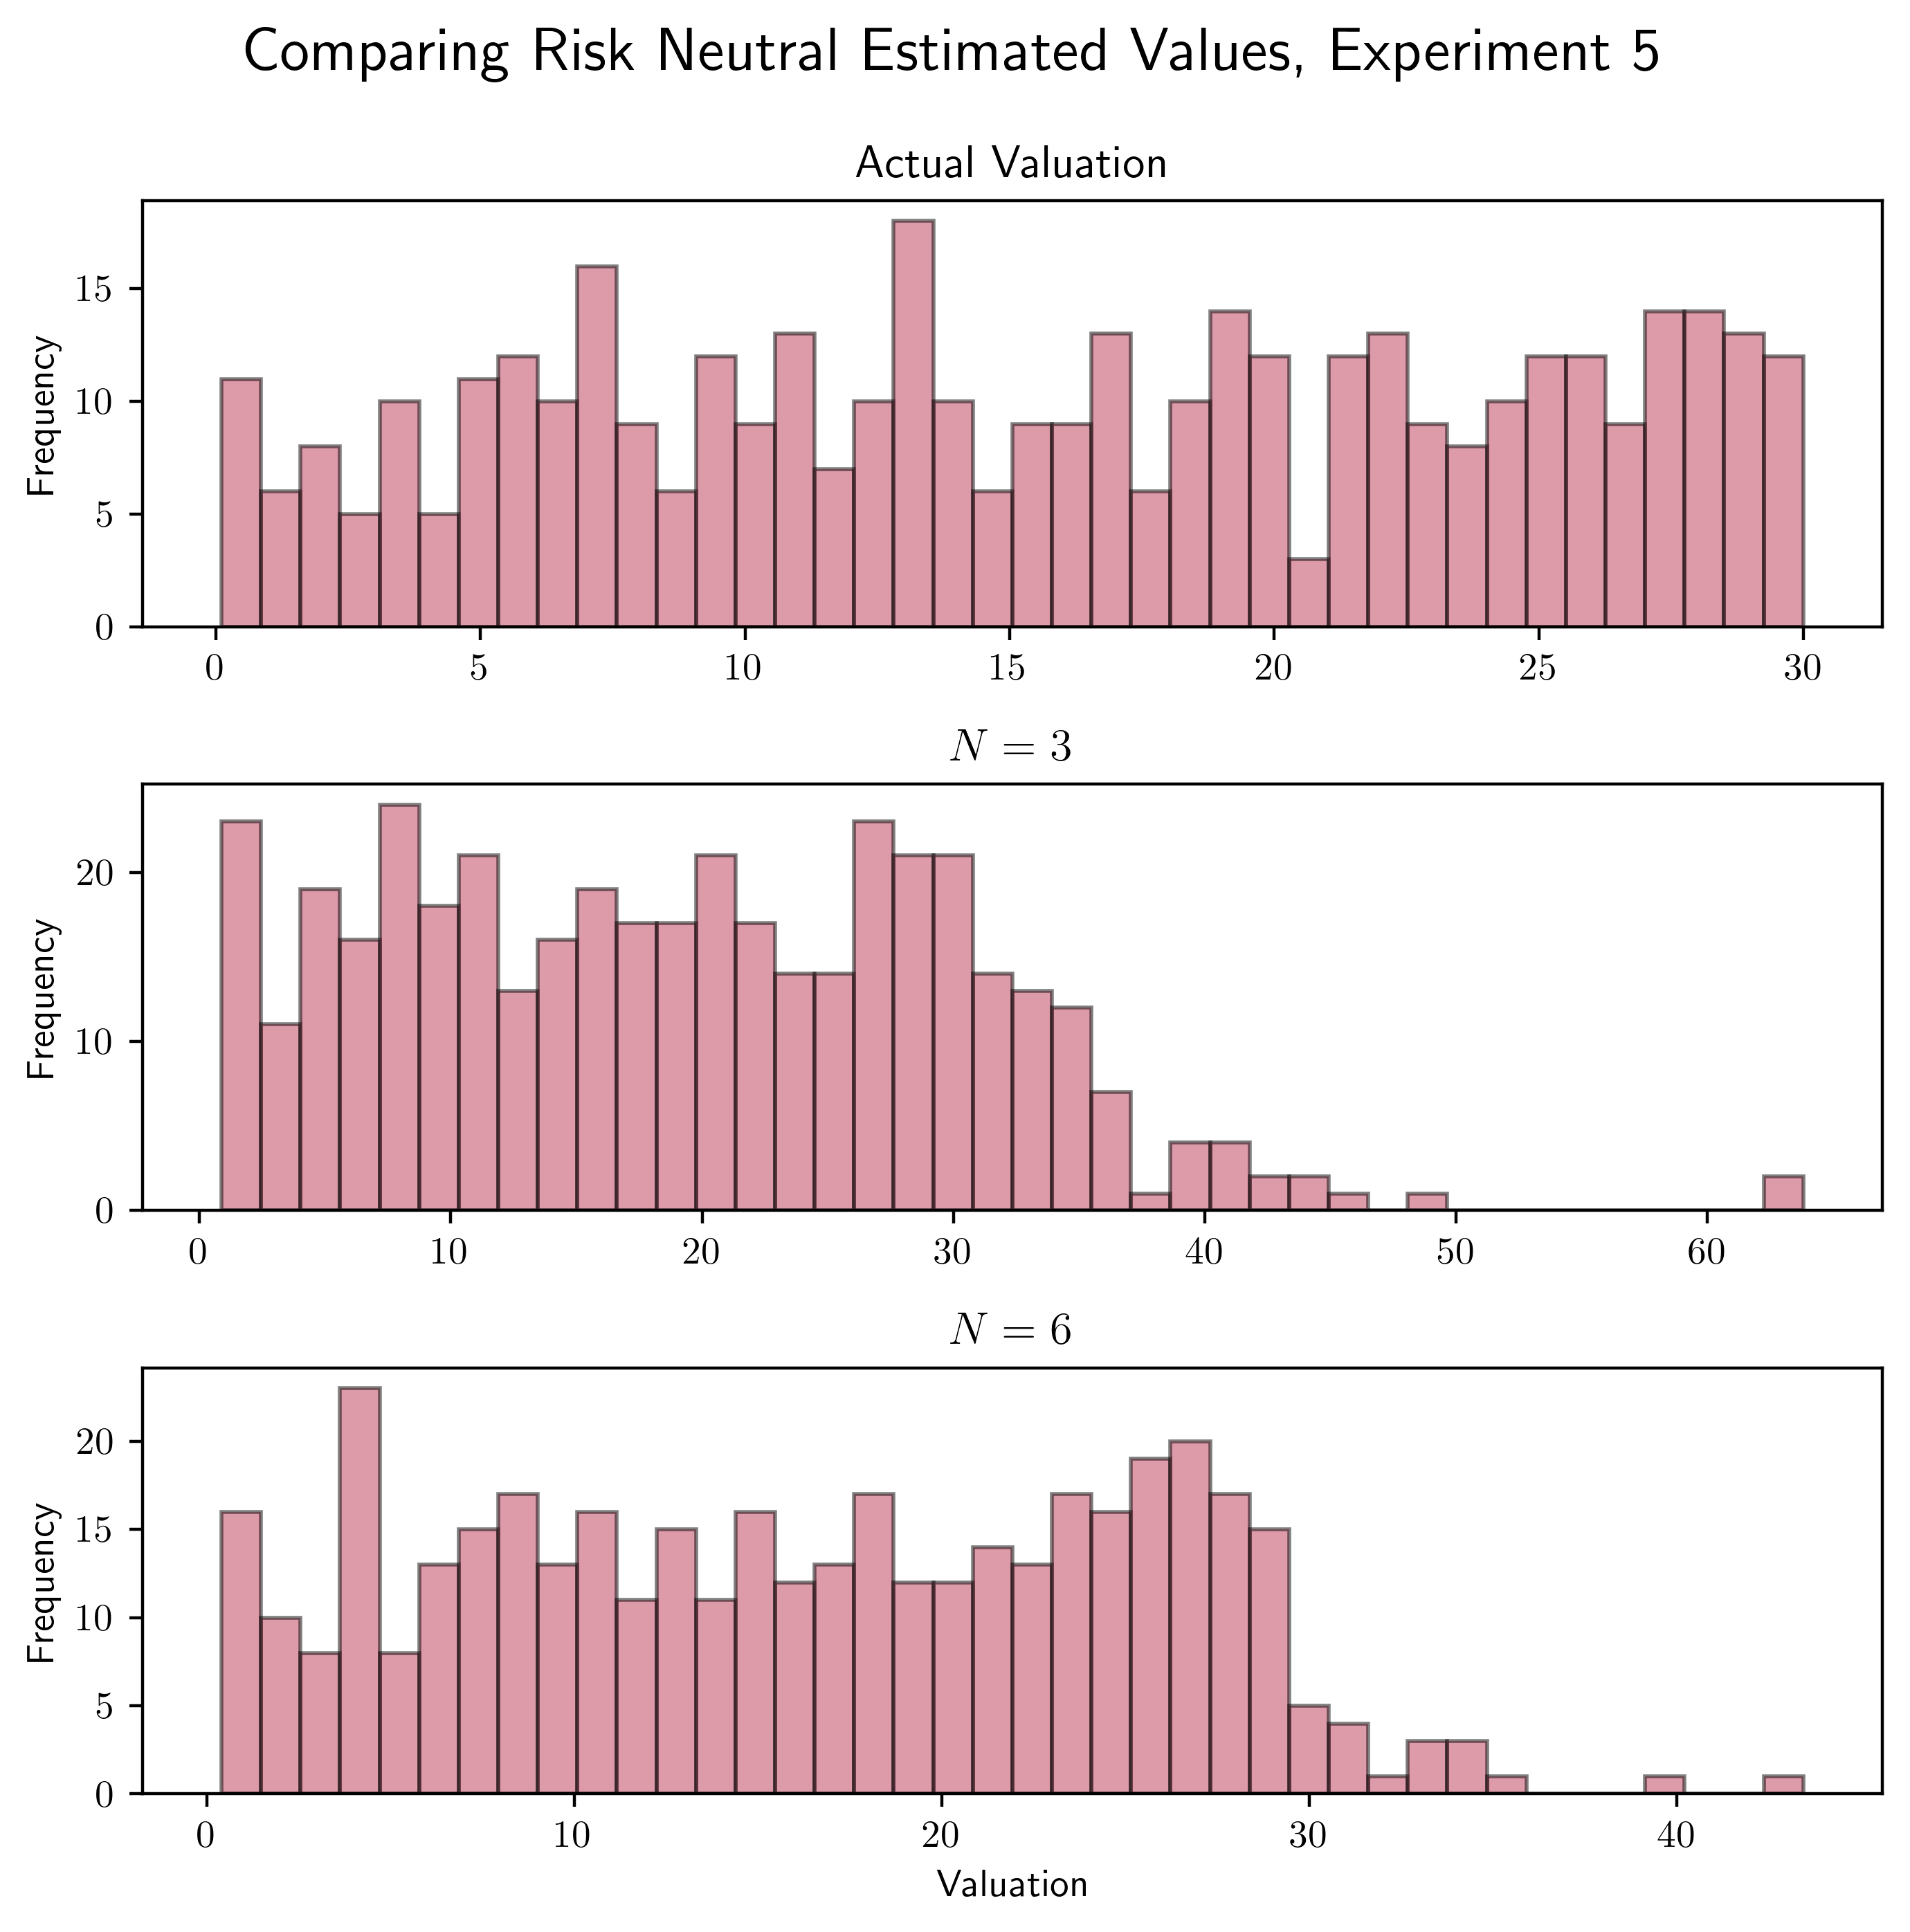

In [28]:
fig7, ax7 = plt.subplots(3, 1, figsize=(7, 7), tight_layout=True, dpi=400)
color = plt.cm.inferno(np.linspace(0.5, 1, 8))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

ax7[0].hist(data.Value, 40, alpha=0.5, histtype='bar', ec='black');
ax7[0].set_title('Actual Valuation', fontsize=12)
ax7[0].set_ylabel(r'Frequency', fontsize=10);

ax7[1].hist(data.EstVal_3_E5_RN, 40, alpha=0.5, label=r'Pooled',
            histtype='bar', ec='black');
ax7[1].set_title('$N = 3$', fontsize=12);
ax7[1].set_ylabel(r'Frequency', fontsize=10);

ax7[2].hist(data.EstVal_6_E5_RN, 40, alpha=0.5, label=r'Pooled',
            histtype='bar', ec='black');
ax7[2].set_title('$N = 6$', fontsize=12)
ax7[2].set_xlabel(r'Valuation', fontsize=10);
ax7[2].set_ylabel(r'Frequency', fontsize=10);

fig7.suptitle('Comparing Risk Neutral Estimated Values, Experiment 5', fontsize=16, y=0.99);

In [29]:
n_obs = len(data.Experiment)

risk_neutral_norms = {
    'L1 Norm': [norm(data.Value - data.EstVal_3_RN, ord=1)/n_obs,
                norm(data.Value - data.EstVal_3_E3_RN, ord=1)/n_obs,
                norm(data.Value - data.EstVal_3_E4_RN, ord=1)/n_obs,
                norm(data.Value - data.EstVal_3_E5_RN, ord=1)/n_obs,
                norm(data.Value - data.EstVal_6_RN, ord=1)/n_obs,
                norm(data.Value - data.EstVal_6_E3_RN, ord=1)/n_obs,
                norm(data.Value - data.EstVal_6_E4_RN, ord=1)/n_obs,
                norm(data.Value - data.EstVal_6_E5_RN, ord=1)/n_obs],
    'L2 Norm': [norm(data.Value - data.EstVal_3_RN, ord=2)/(n_obs ** 0.5),
                 norm(data.Value - data.EstVal_3_E3_RN, ord=2)/(n_obs ** 0.5),
                 norm(data.Value - data.EstVal_3_E4_RN, ord=2)/(n_obs ** 0.5),
                 norm(data.Value - data.EstVal_3_E5_RN, ord=2)/(n_obs ** 0.5),
                 norm(data.Value - data.EstVal_6_RN, ord=2)/(n_obs ** 0.5),
                 norm(data.Value - data.EstVal_6_E3_RN, ord=2)/(n_obs ** 0.5),
                 norm(data.Value - data.EstVal_6_E4_RN, ord=2)/(n_obs ** 0.5),
                 norm(data.Value - data.EstVal_6_E5_RN, ord=2)/(n_obs ** 0.5)]
}

risk_neutral_norms=pd.DataFrame(
    data=risk_neutral_norms,
    index=['$N = 3$, Pooled', '$N = 3$, Experiment 3', '$N = 3$, Experiment 4',
           '$N = 3$, Experiment 5', '$N = 6$, Pooled', '$N = 6$, Experiment 3',
           '$N = 6$, Experiment 4', '$N = 6$, Experiment 5']
)

### Part 2 - Question 4

|                       |  L1 Norm   |  L2 Norm   |
|:---------------------:|:----------:|:----------:|
|    $N = 3$, Pooled    |  3.86074   |  5.49069   |
| $N = 3$, Experiment 3 |  3.53455   |  5.12834   |
| $N = 3$, Experiment 4 |  4.95483   |  6.15492   |
| $N = 3$, Experiment 5 |  3.51949   |  5.04657   |
|    $N = 6$, Pooled    |   1.1498   |  1.67484   |
| $N = 6$, Experiment 3 |  1.07434   |  1.52228   |
| $N = 6$, Experiment 4 |  1.36673   |  1.77798   |
| $N = 6$, Experiment 5 |  1.09736   |  1.68132   |

## Risk-Averse Bayes-Nash Model

### Part 3 - Question 1

In [31]:
bid_percentile = {
    'Number': np.arange(0, 101, 1),
    'Bid3': data.BidC3.quantile(np.arange(0., 1.01, 0.01)),
    'Bid6': data.BidC6.quantile(np.arange(0., 1.01, 0.01))
}

bid_percentile = pd.DataFrame(bid_percentile)

In [32]:
bid_percentile['CDF3'] = cdf_3['Pool'](bid_percentile['Bid3'])
bid_percentile['CDF6'] = cdf_6['Pool'](bid_percentile['Bid6'])
bid_percentile['PDF3'] = pdf_3['Pool'].evaluate(np.array(bid_percentile['Bid3']))
bid_percentile['PDF6'] = pdf_6['Pool'].evaluate(np.array(bid_percentile['Bid6']))
bid_percentile['d_bid'] = bid_percentile['Bid3'] - bid_percentile['Bid6']
bid_percentile['rhs'] = bid_percentile['CDF6']/(5 * bid_percentile['PDF6']) - \
                        bid_percentile['CDF3']/(2 * bid_percentile['PDF3'])

### Part 3 - Question 2

In [33]:
m1 = smf.ols('d_bid ~ rhs - 1', data=bid_percentile).fit()
m2 = smf.ols('d_bid ~ rhs - 1', data=bid_percentile.query('5 <= Number <= 95')).fit()
m3 = smf.ols('d_bid ~ rhs - 1', data=bid_percentile.query('25 <= Number <= 75')).fit()
res1 = Stargazer([m1, m2, m3])
res1.custom_columns(['All Data', '5-95', '25-75'], [1, 1, 1])
res1.show_confidence_intervals(True)
res1.show_degrees_of_freedom(False)
res1.rename_covariates({'rhs': 'θ'})
res1.significant_digits(4)
res1.title('Risk Aversion Parameter Estimates')

In [34]:
res1

### Part 3 - Question 3

In [35]:
theta = m3.params.squeeze()

In [36]:
data['EstVal_3_RA'] = data['BidC3'] + theta * \
                      cdf_3['Pool'](data['BidC3']) / \
                      (2 * pdf_3['Pool'].evaluate(np.array(data['BidC3'])))

data['EstVal_6_RA'] = data['BidC6'] + theta * \
                      cdf_6['Pool'](data['BidC6']) / \
                      (5 * pdf_6['Pool'].evaluate(np.array(data['BidC6'])))

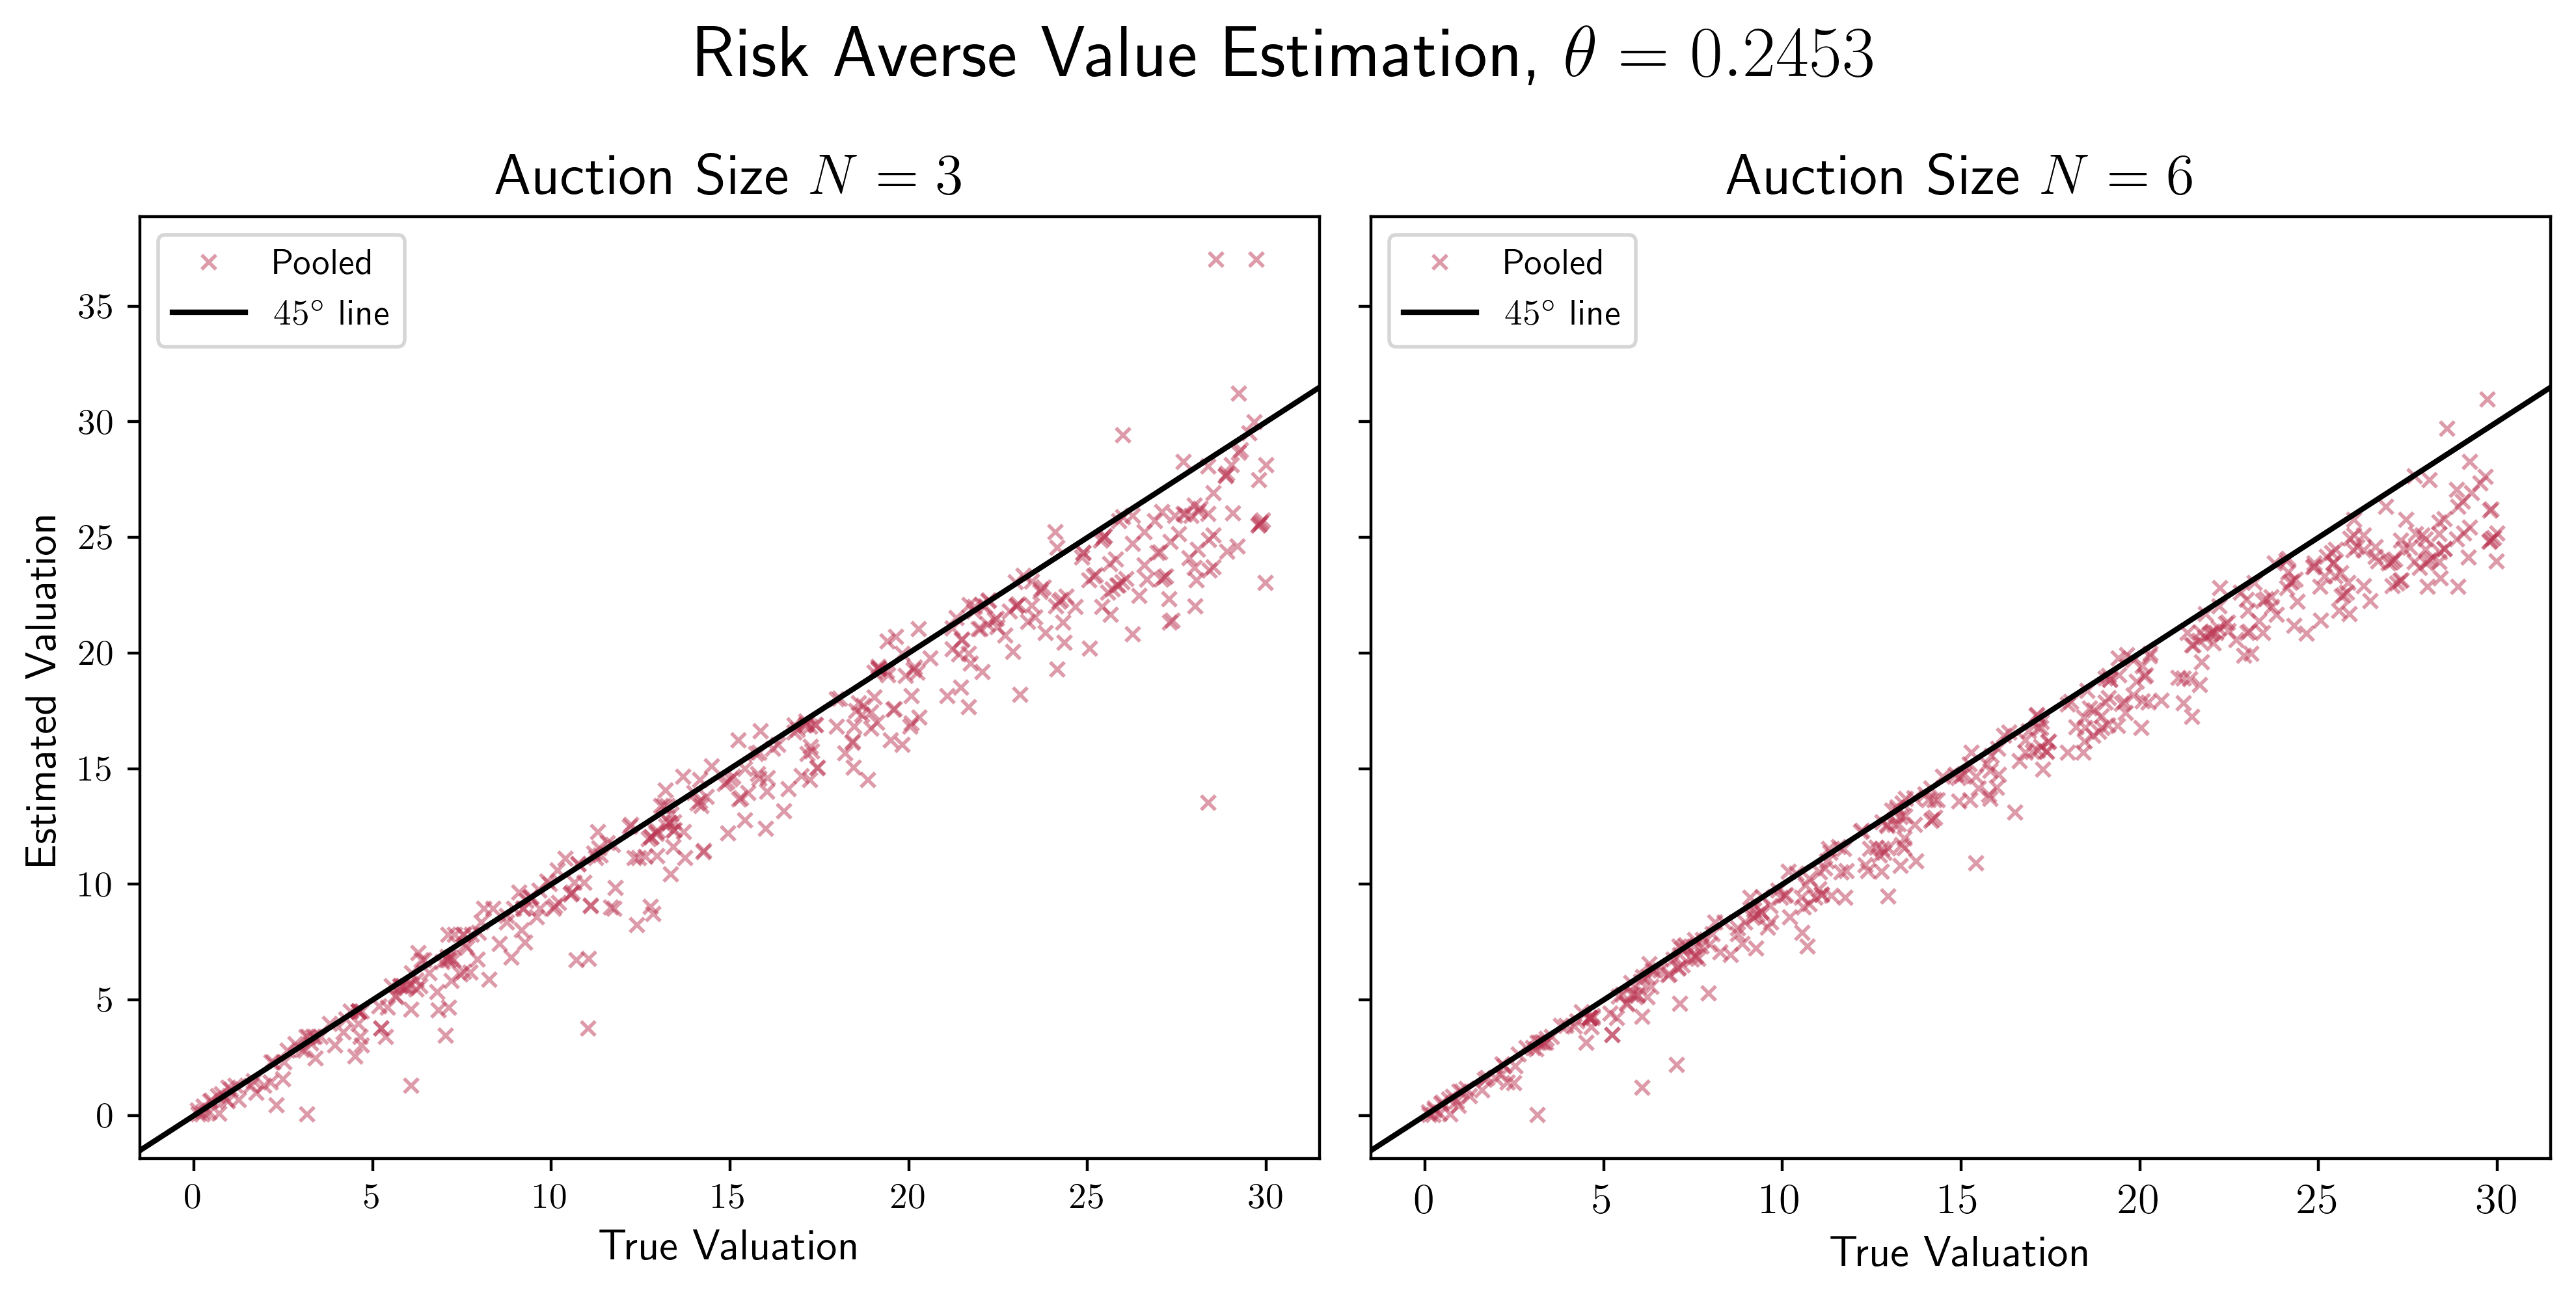

In [37]:
fig8, ax8 = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True, dpi=400, sharey='row')
color = plt.cm.inferno(np.linspace(0, 1, 8))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

ax8[0].plot(data.Value, data.EstVal_3_RA,  label= r'Pooled', marker='x', linestyle='', markersize=4, alpha=0.5)
ax8[0].axline([0, 0], [1, 1], label= r'$45^\circ$ line', color='k')

ax8[1].plot(data.Value, data.EstVal_6_RA,  label= r'Pooled', marker='x', linestyle='', markersize=4, alpha=0.5)
ax8[1].axline([0, 0], [1, 1], label= r'$45^\circ$ line', color='k')

ax8[0].legend(fontsize=10, ncol=1, loc=2);
ax8[0].set_ylabel('Estimated Valuation', fontsize=12);
ax8[0].set_xlabel('True Valuation', fontsize=12);
ax8[0].set_title(r'Auction Size $N = 3$', fontsize=16)

ax8[1].legend(fontsize=10, ncol=1, loc=2);
ax8[1].set_xlabel('True Valuation', fontsize=12);
ax8[1].set_title(r'Auction Size $N = 6$', fontsize=16)

fig8.suptitle(r'Risk Averse Value Estimation, $\theta = {:.4f}$'.format(theta),
              fontsize=20, y=0.99);
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

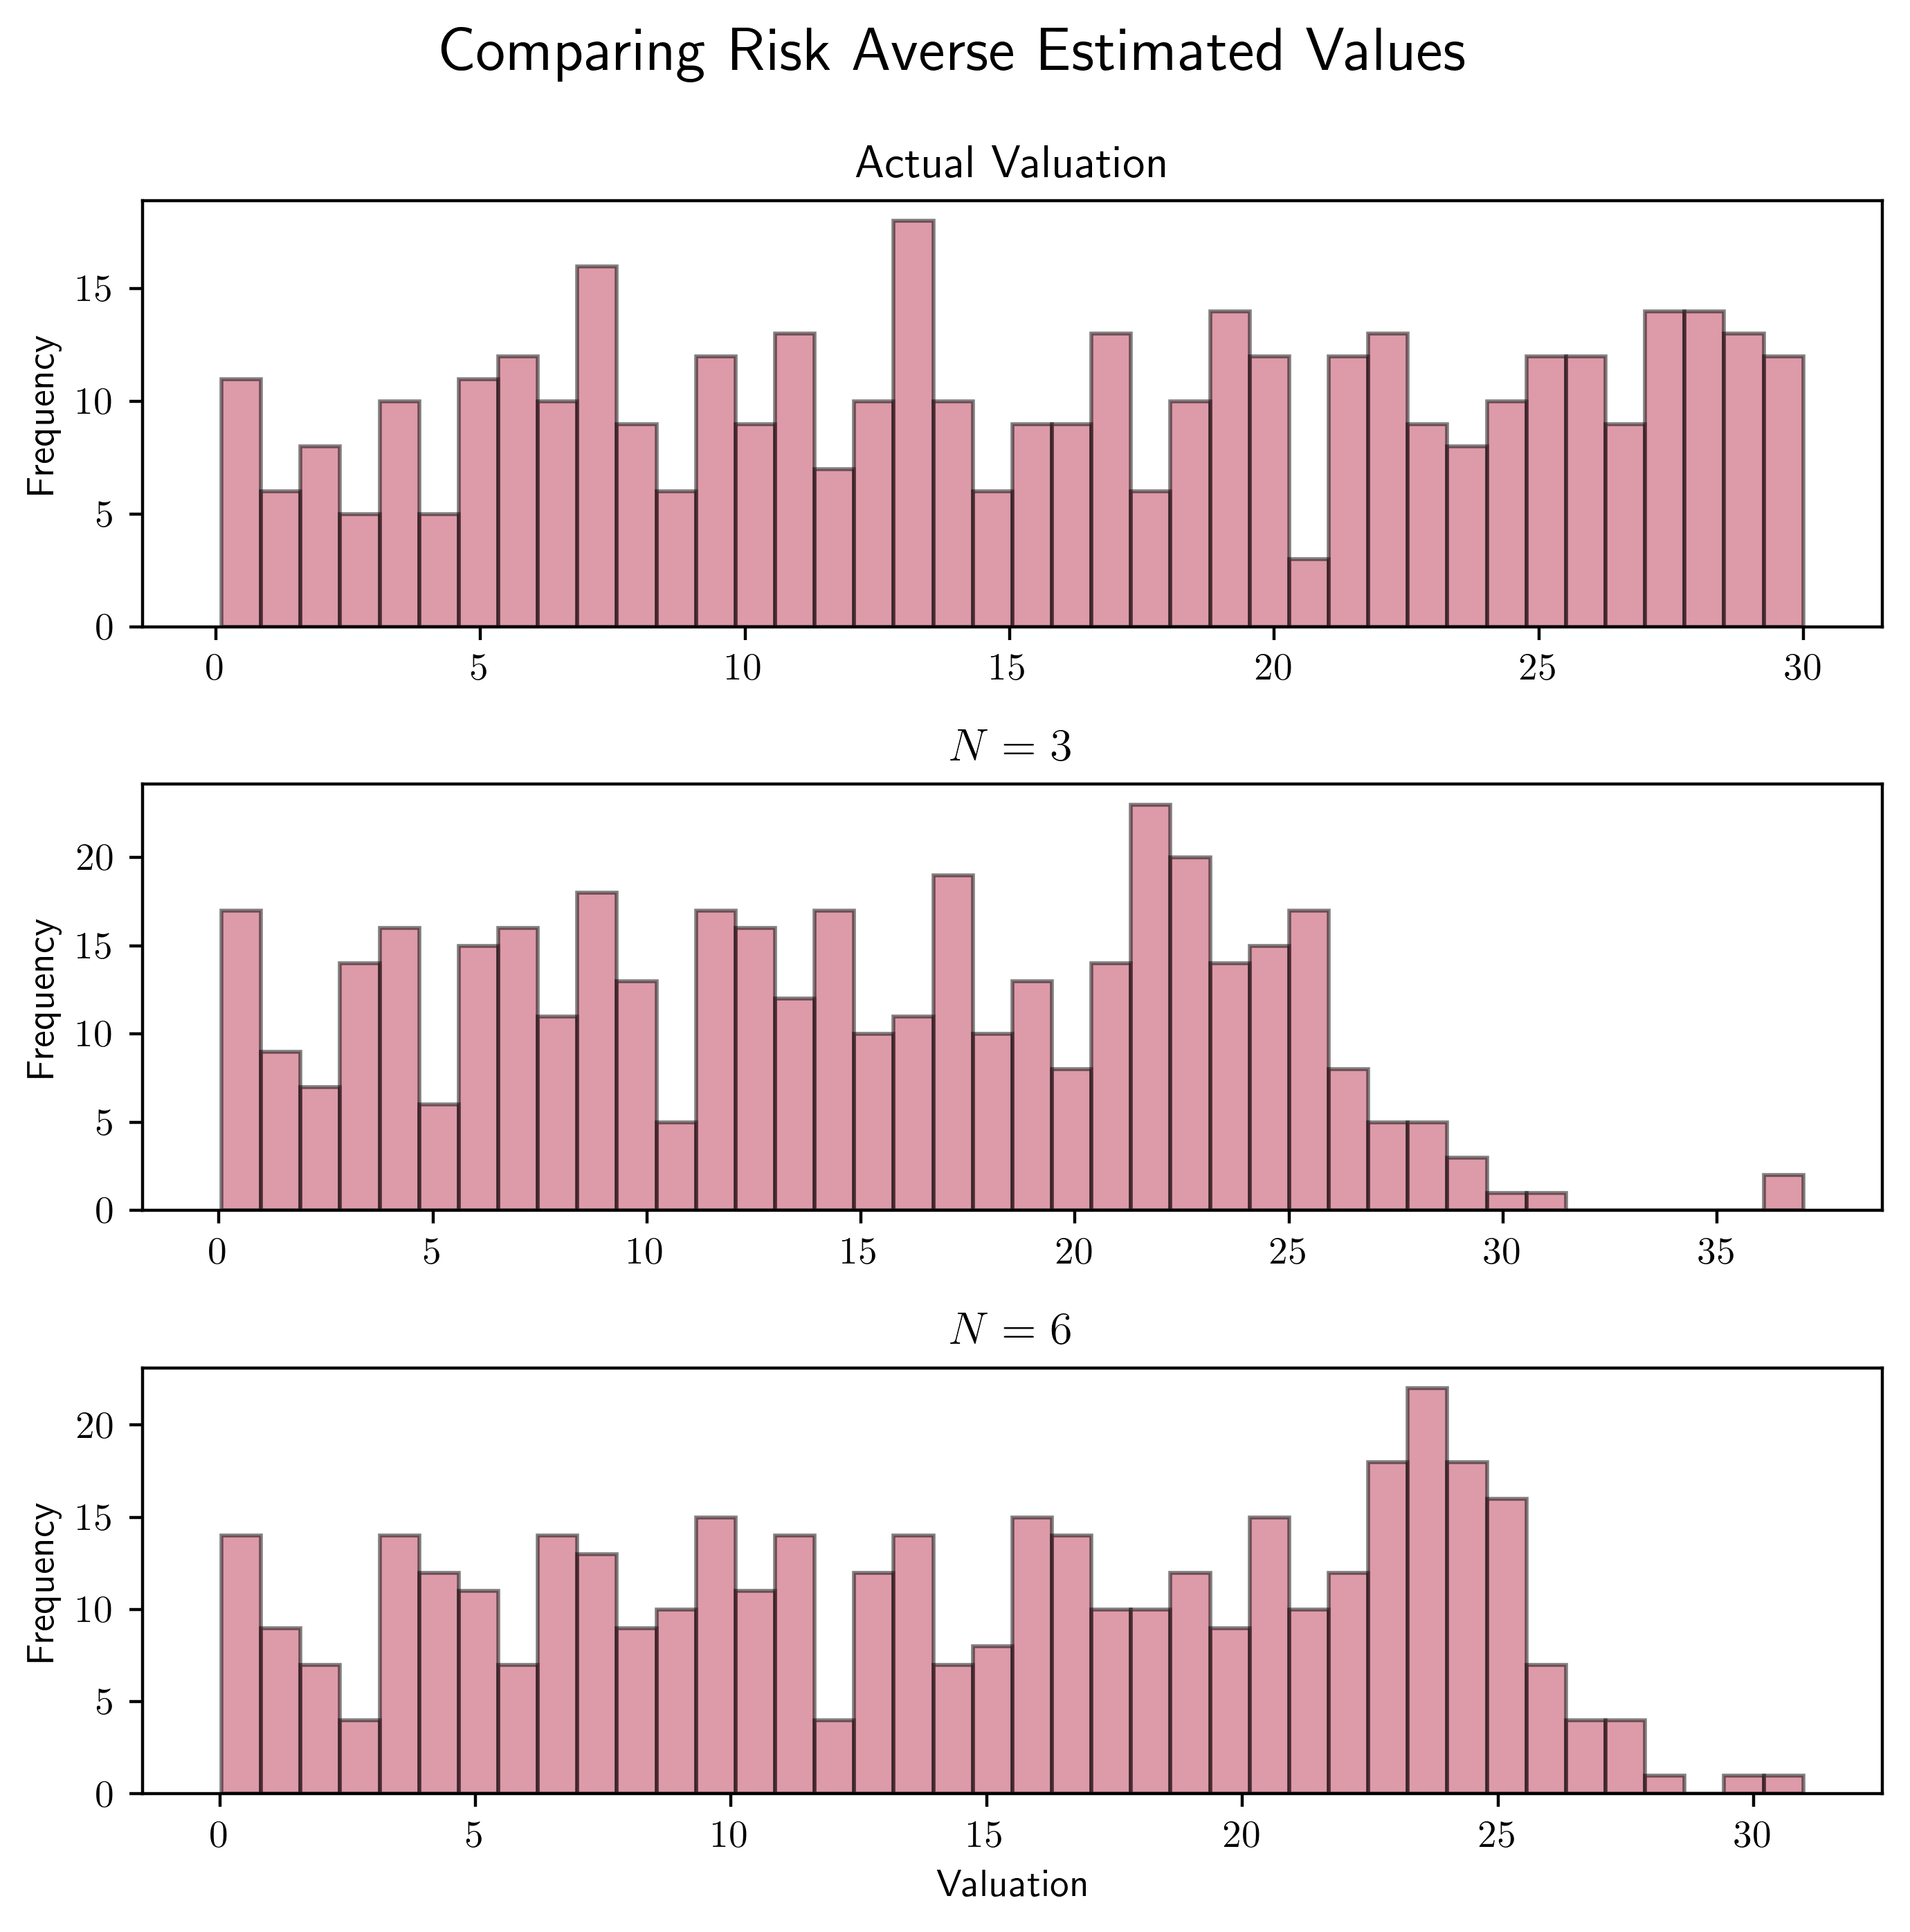

In [39]:
fig9, ax9 = plt.subplots(3, 1, figsize=(7, 7), tight_layout=True, dpi=400)
color = plt.cm.inferno(np.linspace(0.5, 1, 8))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

ax9[0].hist(data.Value, 40, alpha=0.5, histtype='bar', ec='black');
ax9[0].set_title('Actual Valuation', fontsize=12);
ax9[0].set_ylabel(r'Frequency', fontsize=10);

ax9[1].hist(data.EstVal_3_RA, 40, alpha=0.5, histtype='bar', ec='black');
ax9[1].set_title('$N = 3$', fontsize=12);
ax9[1].set_ylabel(r'Frequency', fontsize=10);

ax9[2].hist(data.EstVal_6_RA, 40, alpha=0.5, histtype='bar', ec='black');
ax9[2].set_title('$N = 6$', fontsize=12);
ax9[2].set_xlabel(r'Valuation', fontsize=10);
ax9[2].set_ylabel(r'Frequency', fontsize=10);

fig9.suptitle('Comparing Risk Averse Estimated Values', fontsize=16, y=0.99);

In [40]:
n_obs = len(data.Experiment)

risk_averse_norms = {
    'L1 Norm': [norm(data.Value - data.EstVal_3_RA, ord=1)/n_obs,
                norm(data.Value - data.EstVal_6_RA, ord=1)/n_obs],
    'L2 Norm': [norm(data.Value - data.EstVal_3_RA, ord=2)/(n_obs ** 0.5),
                norm(data.Value - data.EstVal_6_RA, ord=2)/(n_obs ** 0.5)]
}

risk_averse_norms = pd.DataFrame(
    data=risk_averse_norms,
    index=['$N = 3$', '$N = 6$']
)

|         |   L1 Norm |   L2 Norm |
|:-------:|:---------:|:---------:|
| $N = 3$ |   1.45746 |   2.16691 |
| $N = 6$ |   1.38659 |   1.90917 |